In [3756]:

import importlib
import data_prep as dp
import macro_utils
import pandas as pd
importlib.reload(dp)
importlib.reload(macro_utils)
print(dir(dp))  # Check if functions appear now
import matplotlib.pyplot as plt
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
import numpy as np

Device set to use mps:0


['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'calculate_sentiment', 'calculate_sentiment_stats', 'datetime', 'download_vix_data', 'load_data', 'load_macro_df', 'macro_analysis', 'merge_dataframes', 'micro_analysis', 'np', 'pd', 'pipe', 'pipeline', 're', 'sort_by_date', 'tqdm', 'yf']


In [132]:
#optional
#df = dp.macro_analysis('./../clean_macro_5y_news_1kcap.csv', 'description', 'title')

# OPTIONAL: concat recent news with existing df for trading.

In [3739]:
df_live = dp.macro_analysis('./../clean_macro_05-05-25_news.csv', 'description', 'title')

Step 1: Loading data
Available columns in CSV: ['topic', 'title', 'description', 'source', 'published_at', 'url']
Columns after loading: ['topic', 'title', 'description', 'source', 'published_at', 'url', 'date']
Data shape after loading: (6947, 7)
Step 2: Sorting by date
Min date: 2025-04-16 00:00:00, Max date: 2025-05-05 00:00:00
Columns after sorting: ['topic', 'title', 'description', 'source', 'published_at', 'url', 'date']
Step 3: Calculating summary sentiment
Analyzing sentiment for 6947 entries in column 'description'...


Sentiment analysis for 'description': 100%|██████████| 6947/6947 [01:34<00:00, 73.35it/s] 


Columns after summary sentiment: ['topic', 'title', 'description', 'source', 'published_at', 'url', 'date', 'description_sentiment_summary', 'description_sentiment_label_summary']
Step 4: Calculating headline sentiment
Analyzing sentiment for 6947 entries in column 'title'...


Sentiment analysis for 'title': 100%|██████████| 6947/6947 [01:17<00:00, 89.65it/s] 


Columns after headline sentiment: ['topic', 'title', 'description', 'source', 'published_at', 'url', 'date', 'description_sentiment_summary', 'description_sentiment_label_summary', 'title_sentiment_headline', 'title_sentiment_label_headline']
Step 5: Calculating sentiment stats
Inside calculate_sentiment_stats
Input df shape: (6947, 11)
Input columns: ['topic', 'title', 'description', 'source', 'published_at', 'url', 'date', 'description_sentiment_summary', 'description_sentiment_label_summary', 'title_sentiment_headline', 'title_sentiment_label_headline']
Date min: 2025-04-16 00:00:00, max: 2025-05-05 00:00:00
Filtered df shape: (6947, 11)
Looking for columns: description_sentiment_summary and title_sentiment_headline
Output columns: ['date', 'summary_mean', 'summary_min', 'summary_max', 'summary_pos_count', 'summary_neg_count', 'headline_mean', 'headline_min', 'headline_max', 'headline_pos_count', 'headline_neg_count', 'overall_mean', 'overall_min', 'overall_max', 'overall_pos_count'

[*********************100%***********************]  1 of 1 completed

VIX data shape: (12, 2)
VIX columns: ['date', 'vix_close']
Step 7: Merging dataframes
Final data shape: (17, 17)


In [3749]:
#df = pd.read_csv('./../data/Sentiment Macro 7Y News 2.5K Cap.csv') #adjust for live/most recent df news under /data/live
df = pd.read_csv('./../data/live/7y_up_to_4_17_2025_news.csv')


In [3750]:
df.tail()

,date,date.1,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,...,overall_pos_count,overall_neg_count,vix_target,mean_sentiment_decay,shock_pos,shock_neg,sentiment_dominance,dominance_trigger,vix_7d_pct,vix_zscore
1899,2025-04-12,2025-04-12,-0.089461,-0.957227,0.948515,90,43,-0.008691,-0.941981,0.939109,...,195,71,30.889999,-0.304711,0.943812,-0.949604,47,0,0.426790,0.340215
1900,2025-04-13,2025-04-13,-0.086733,-0.972444,0.952317,74,31,-0.158017,-0.968547,0.952738,...,145,65,30.889999,-0.049076,0.952528,-0.970495,43,0,0.386445,0.313508
1901,2025-04-14,2025-04-14,-0.063972,-0.972737,0.948741,239,123,-0.219557,-0.973235,0.940637,...,447,277,30.889999,-0.122375,0.944689,-0.972986,116,0,0.386445,0.283756
1902,2025-04-15,2025-04-15,-0.174286,-0.975042,0.950775,181,117,-0.138407,-0.974432,0.948124,...,376,220,30.120001,-0.141765,0.949450,-0.974737,64,0,0.351885,0.185777
1903,2025-04-16,2025-04-16,-0.254442,-0.974785,0.947952,205,169,-0.164961,-0.974998,0.955106,...,452,296,32.639999,-0.156347,0.951529,-0.974891,36,0,0.499311,0.382230


In [3751]:
df_live.tail()

,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_max,overall_pos_count,overall_neg_count,vix_target
12,2025-04-28,-0.096253,-0.975737,0.950602,152,90,0.048906,-0.971171,0.954707,192,50,-0.023674,-0.973454,0.952654,344,140,25.150000
13,2025-04-29,-0.256989,-0.975858,0.953012,282,247,-0.174279,-0.973403,0.952239,337,192,-0.215634,-0.974631,0.952625,619,439,24.170000
14,2025-04-30,-0.257138,-0.975998,0.953903,377,380,-0.172480,-0.976034,0.953903,439,318,-0.214809,-0.976016,0.953903,816,698,24.700001
15,2025-05-01,-0.214649,-0.976830,0.950811,304,256,-0.123903,-0.974128,0.950811,371,189,-0.169276,-0.975479,0.950811,675,445,24.600000
16,2025-05-02,-0.053660,-0.976696,0.954615,357,177,-0.039443,-0.973332,0.945728,387,147,-0.046552,-0.975014,0.950172,744,324,22.680000


In [3752]:
# Ensure 'date' columns are datetime
df['date'] = pd.to_datetime(df['date'])
df_live['date'] = pd.to_datetime(df_live['date'])

# Remove overlap: drop April 10 from df_live if it exists in df
df_live_trimmed = df_live[df_live['date'] > df['date'].max()]



In [3753]:
df_live_trimmed.tail()

,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_max,overall_pos_count,overall_neg_count,vix_target
12,2025-04-28,-0.096253,-0.975737,0.950602,152,90,0.048906,-0.971171,0.954707,192,50,-0.023674,-0.973454,0.952654,344,140,25.150000
13,2025-04-29,-0.256989,-0.975858,0.953012,282,247,-0.174279,-0.973403,0.952239,337,192,-0.215634,-0.974631,0.952625,619,439,24.170000
14,2025-04-30,-0.257138,-0.975998,0.953903,377,380,-0.172480,-0.976034,0.953903,439,318,-0.214809,-0.976016,0.953903,816,698,24.700001
15,2025-05-01,-0.214649,-0.976830,0.950811,304,256,-0.123903,-0.974128,0.950811,371,189,-0.169276,-0.975479,0.950811,675,445,24.600000
16,2025-05-02,-0.053660,-0.976696,0.954615,357,177,-0.039443,-0.973332,0.945728,387,147,-0.046552,-0.975014,0.950172,744,324,22.680000


In [3754]:
df = pd.concat([df, df_live_trimmed], ignore_index=True)

In [3755]:
df.tail()

,date,date.1,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,...,overall_pos_count,overall_neg_count,vix_target,mean_sentiment_decay,shock_pos,shock_neg,sentiment_dominance,dominance_trigger,vix_7d_pct,vix_zscore
1915,2025-04-28,NaN,-0.096253,-0.975737,0.950602,152,90,0.048906,-0.971171,0.954707,...,344,140,25.150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1916,2025-04-29,NaN,-0.256989,-0.975858,0.953012,282,247,-0.174279,-0.973403,0.952239,...,619,439,24.170000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1917,2025-04-30,NaN,-0.257138,-0.975998,0.953903,377,380,-0.172480,-0.976034,0.953903,...,816,698,24.700001,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1918,2025-05-01,NaN,-0.214649,-0.976830,0.950811,304,256,-0.123903,-0.974128,0.950811,...,675,445,24.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1919,2025-05-02,NaN,-0.053660,-0.976696,0.954615,357,177,-0.039443,-0.973332,0.945728,...,744,324,22.680000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3757]:
df = df.drop(columns=['date.1'])

In [3748]:
df.tail()


,date,date.1,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
1899,2025-04-12,2025-04-12,-0.089461,-0.957227,0.948515,90,43,-0.008691,-0.941981,0.939109,...,0.426790,0.340215,30.434149,11.581772,0.039359,26.917334,26.917334,29.561233,11.582488,-0.228267
1900,2025-04-13,2025-04-13,-0.086733,-0.972444,0.952317,74,31,-0.158017,-0.968547,0.952738,...,0.386445,0.313508,30.463558,11.202517,0.038067,27.125000,27.125000,29.404056,11.219157,-0.203140
1901,2025-04-14,2025-04-14,-0.063972,-0.972737,0.948741,239,123,-0.219557,-0.973235,0.940637,...,0.386445,0.283756,30.491071,10.835645,0.036816,27.429000,27.429000,29.276633,10.862432,-0.170094
1902,2025-04-15,2025-04-15,-0.174286,-0.975042,0.950775,181,117,-0.138407,-0.974432,0.948124,...,0.351885,0.185777,30.467131,10.480690,-0.033121,27.775000,27.775000,29.179754,10.512887,-0.133622
1903,2025-04-16,2025-04-16,-0.254442,-0.974785,0.947952,205,169,-0.164961,-0.974998,0.955106,...,0.499311,0.382230,30.607316,10.151497,0.200235,28.095333,28.095333,29.109791,10.171718,-0.099733


In [3758]:
#df = pd.read_csv('./../data/live/7y_up_to_4_17_2025_news.csv')
df = macro_utils.calculate_stats(df, threshold_abs=9, window=30, window_prev=30)
df['vix_target'] = np.log(df['vix_target'])


In [3759]:
df.tail()

,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
1915,2025-04-28,-0.096253,-0.975737,0.950602,152,90,0.048906,-0.971171,0.954707,192,...,-0.185821,-0.874807,29.449357,7.416349,-0.579713,32.387000,32.387000,30.145885,6.950796,0.322426
1916,2025-04-29,-0.256989,-0.975858,0.953012,282,247,-0.174279,-0.973403,0.952239,337,...,-0.217546,-1.007963,29.108753,7.293412,-0.677153,32.482667,32.482667,30.296645,6.748147,0.323944
1917,2025-04-30,-0.257138,-0.975998,0.953903,377,380,-0.172480,-0.976034,0.953903,439,...,-0.179947,-0.964551,28.824318,7.139717,-0.577658,32.545667,32.545667,30.441743,6.550984,0.321161
1918,2025-05-01,-0.214649,-0.976830,0.950811,304,256,-0.123903,-0.974128,0.950811,371,...,-0.246324,-1.002034,28.551781,6.985768,-0.565690,32.626333,32.626333,30.582684,6.359608,0.321348
1919,2025-05-02,-0.053660,-0.976696,0.954615,357,177,-0.039443,-0.973332,0.945728,387,...,-0.235076,-1.251975,28.172957,6.914125,-0.794454,32.720667,22.680000,30.072834,6.460225,-1.144362


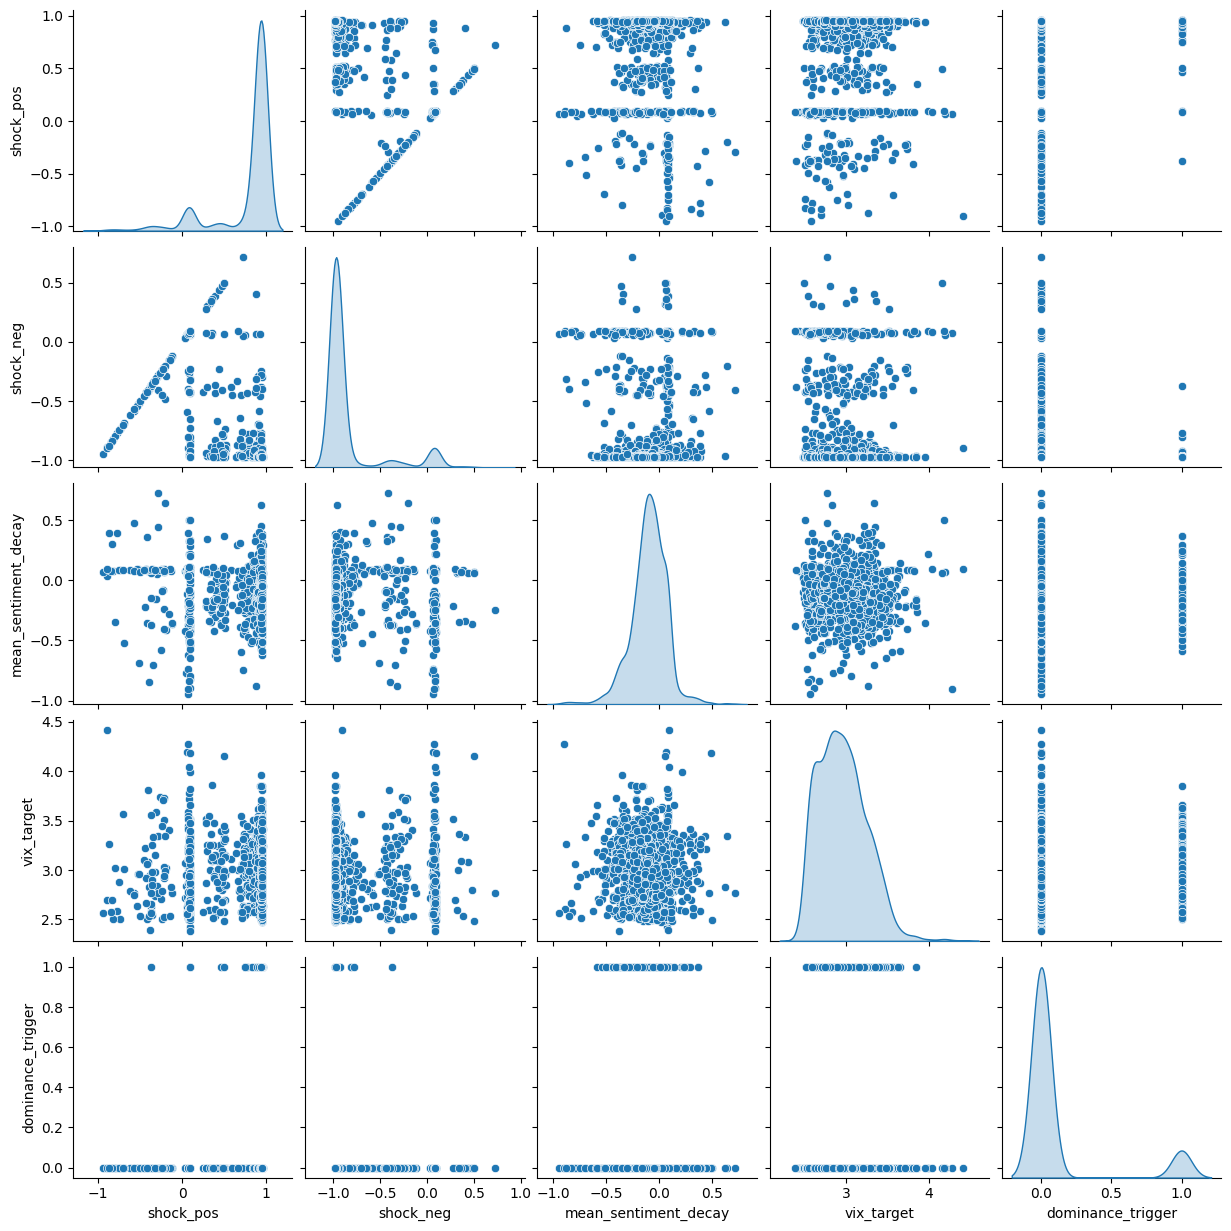

In [2910]:
import seaborn as sns
sns.pairplot(df, vars=['shock_pos', 'shock_neg', 'mean_sentiment_decay', 'vix_target', 'dominance_trigger'], diag_kind='kde')


In [3760]:
feature_sets = [ #for testing, winner was the first one, decreasing in quality for this model sequentially
    ['shock_neg', 'dominance_trigger'],
    ['shock_neg', 'sentiment_dominance'],
    ['shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_pos', 'shock_neg', 'sentiment_dominance', 'overall_min'],
    ['shock_neg', 'mean_sentiment_decay', 'overall_min', 'sentiment_dominance']
]
selected_features = feature_sets[0]

In [3761]:
df.index = pd.to_datetime(df['date'])
df.tail()

,date,summary_mean,summary_min,summary_max,summary_pos_count,summary_neg_count,headline_mean,headline_min,headline_max,headline_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2025-04-28,2025-04-28,-0.096253,-0.975737,0.950602,152,90,0.048906,-0.971171,0.954707,192,...,-0.185821,-0.874807,29.449357,7.416349,-0.579713,32.387000,32.387000,30.145885,6.950796,0.322426
2025-04-29,2025-04-29,-0.256989,-0.975858,0.953012,282,247,-0.174279,-0.973403,0.952239,337,...,-0.217546,-1.007963,29.108753,7.293412,-0.677153,32.482667,32.482667,30.296645,6.748147,0.323944
2025-04-30,2025-04-30,-0.257138,-0.975998,0.953903,377,380,-0.172480,-0.976034,0.953903,439,...,-0.179947,-0.964551,28.824318,7.139717,-0.577658,32.545667,32.545667,30.441743,6.550984,0.321161
2025-05-01,2025-05-01,-0.214649,-0.976830,0.950811,304,256,-0.123903,-0.974128,0.950811,371,...,-0.246324,-1.002034,28.551781,6.985768,-0.565690,32.626333,32.626333,30.582684,6.359608,0.321348
2025-05-02,2025-05-02,-0.053660,-0.976696,0.954615,357,177,-0.039443,-0.973332,0.945728,387,...,-0.235076,-1.251975,28.172957,6.914125,-0.794454,32.720667,22.680000,30.072834,6.460225,-1.144362


In [3762]:
df = df.drop(columns=['date'])

In [3763]:
df = df.drop(columns=['summary_max', 'summary_pos_count', 'headline_max', 'overall_max', 'shock_pos'])

In [3764]:
#df['vix_target_log'] = np.log(df['vix_target'])
#df['vix_target_log_ret'] = df['vix_target_log'].diff().dropna()

# Train: Post-COVID to end of 2023
#train_df = df[(df.index >= "2018-05-01") & (df.index <= "2024-10-15")]
train_df = df[(df.index <= "2024-10-15")]
# Test: Recent years
test_df = df[df.index >= "2024-10-16"]
print(f"Train set: {len(train_df)} rows")
print(f"Test set: {len(test_df)} rows")

df_model = train_df.dropna(subset=feature_sets[4] + ['vix_zscore']).copy() #i chose first set.
X = df_model[feature_sets[0]]
y = df_model['vix_ewm_zscore_flat']


Train set: 1721 rows
Test set: 199 rows


In [3765]:
X.isna().sum()
y.isna().sum()

np.int64(0)

In [3766]:
train_df.head()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2017-12-13,0.086767,0.086767,0,-0.533592,-0.533592,0,2,-0.223413,-0.223413,2,...,NaN,NaN,10.180000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-12-14,0.091055,0.091055,0,0.091055,0.091055,1255,0,0.091055,0.091055,2510,...,NaN,NaN,10.340167,0.219203,0.683537,10.180000,10.180000,10.180000,NaN,NaN
2017-12-26,0.090923,0.090923,0,0.090923,0.090923,1,0,0.090923,0.090923,2,...,NaN,NaN,10.308086,0.161318,-0.360072,10.335000,10.335000,10.260084,0.109601,0.683537
2017-12-27,0.505010,0.060151,0,0.086224,0.082667,2,0,0.295617,0.071409,4,...,NaN,NaN,10.352699,0.154126,0.761071,10.306667,10.306667,10.276658,0.080952,0.370704
2018-01-02,0.065905,0.065905,0,0.085878,0.085878,1,0,0.075892,0.075892,2,...,NaN,NaN,10.220121,0.303267,-1.484241,10.347500,10.347500,10.296177,0.074564,0.688304


In [3770]:
test_df_trade = test_df.copy()

In [3769]:
test_df.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2025-04-28,-0.096253,-0.975737,90,0.048906,-0.971171,192,50,-0.023674,-0.973454,344,...,-0.185821,-0.874807,29.449357,7.416349,-0.579713,32.387000,32.387000,30.145885,6.950796,0.322426
2025-04-29,-0.256989,-0.975858,247,-0.174279,-0.973403,337,192,-0.215634,-0.974631,619,...,-0.217546,-1.007963,29.108753,7.293412,-0.677153,32.482667,32.482667,30.296645,6.748147,0.323944
2025-04-30,-0.257138,-0.975998,380,-0.172480,-0.976034,439,318,-0.214809,-0.976016,816,...,-0.179947,-0.964551,28.824318,7.139717,-0.577658,32.545667,32.545667,30.441743,6.550984,0.321161
2025-05-01,-0.214649,-0.976830,256,-0.123903,-0.974128,371,189,-0.169276,-0.975479,675,...,-0.246324,-1.002034,28.551781,6.985768,-0.565690,32.626333,32.626333,30.582684,6.359608,0.321348
2025-05-02,-0.053660,-0.976696,177,-0.039443,-0.973332,387,147,-0.046552,-0.975014,744,...,-0.235076,-1.251975,28.172957,6.914125,-0.794454,32.720667,22.680000,30.072834,6.460225,-1.144362


In [2920]:
percentile_markov = 0.005

In [2921]:
transition_matrix, results, df_model = macro_utils.regime_t_markov_model(X, y, df_model, k=2, percentile=percentile_markov)

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [2922]:
df_model.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,regime_t+1,regime_t+1_raw
date,,,,,,,,,,,,,,,,,,,,,
2024-10-11,-0.313376,-0.972448,58,-0.157393,-0.971905,57,48,-0.235385,-0.972176,104,...,0.501729,18.034666,18.034666,18.030169,1.283896,0.003503,0.065116,1,1.0,0.122250
2024-10-12,0.181630,-0.959148,9,0.054226,-0.946041,31,6,0.117928,-0.952595,59,...,0.211239,18.127000,18.127000,18.036416,1.242025,0.072932,0.122250,1,1.0,0.245281
2024-10-13,-0.280690,-0.969393,10,-0.232838,-0.916358,12,8,-0.256764,-0.942875,22,...,0.204007,18.214666,18.214666,18.047916,1.202117,0.138714,0.245281,1,1.0,0.495994
2024-10-14,0.009047,-0.974299,24,-0.044218,-0.972195,43,20,-0.017585,-0.973247,82,...,0.197043,18.319333,18.319333,18.065427,1.164669,0.218007,0.495994,1,1.0,0.787314
2024-10-15,-0.242439,-0.975493,63,-0.210137,-0.972273,74,56,-0.226288,-0.973883,141,...,0.556791,18.404667,18.404667,18.087313,1.129657,0.280929,0.787314,1,NaN,NaN


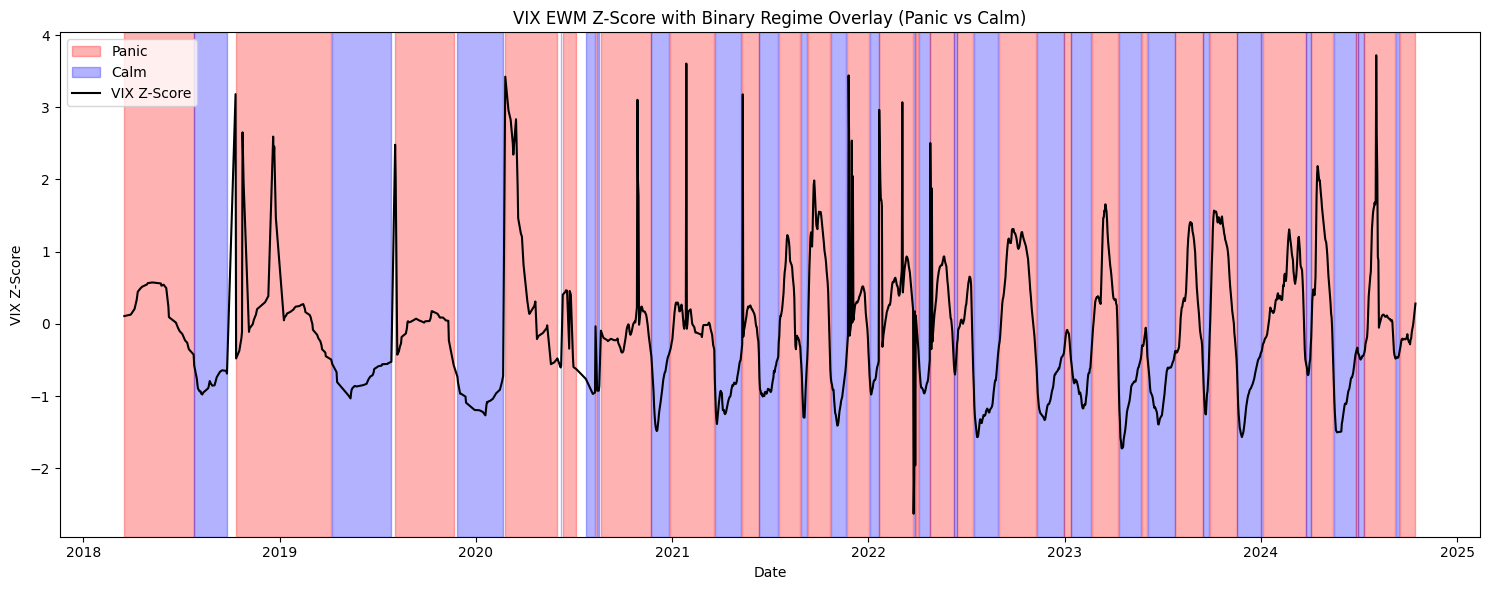

In [2923]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 6))
plt.plot(df_model.index, df_model['vix_ewm_zscore_flat'], label='VIX_t (EWM Z-Score)', color='black')

# Efficient binary shading
start_idx = None
current_regime = None

for i in range(len(df_model)):
    regime = df_model['regime_t'].iloc[i]
    
    if regime != current_regime:
        if current_regime is not None:
            # Draw previous span
            plt.axvspan(df_model.index[start_idx], df_model.index[i - 1],
                        color='red' if current_regime == 1 else 'blue', alpha=0.3)
        # Start new span
        start_idx = i
        current_regime = regime

# Draw last span
if current_regime is not None:
    plt.axvspan(df_model.index[start_idx], df_model.index[-1],
                color='red' if current_regime == 1 else 'blue', alpha=0.3)

# Legend and labels
panic_patch = mpatches.Patch(color='red', alpha=0.3, label='Panic')
calm_patch = mpatches.Patch(color='blue', alpha=0.3, label='Calm')
plt.legend(handles=[panic_patch, calm_patch, plt.Line2D([], [], color='black', label='VIX Z-Score')])

plt.title('VIX EWM Z-Score with Binary Regime Overlay (Panic vs Calm)')
plt.xlabel('Date')
plt.ylabel('VIX Z-Score')
plt.tight_layout()
plt.show()


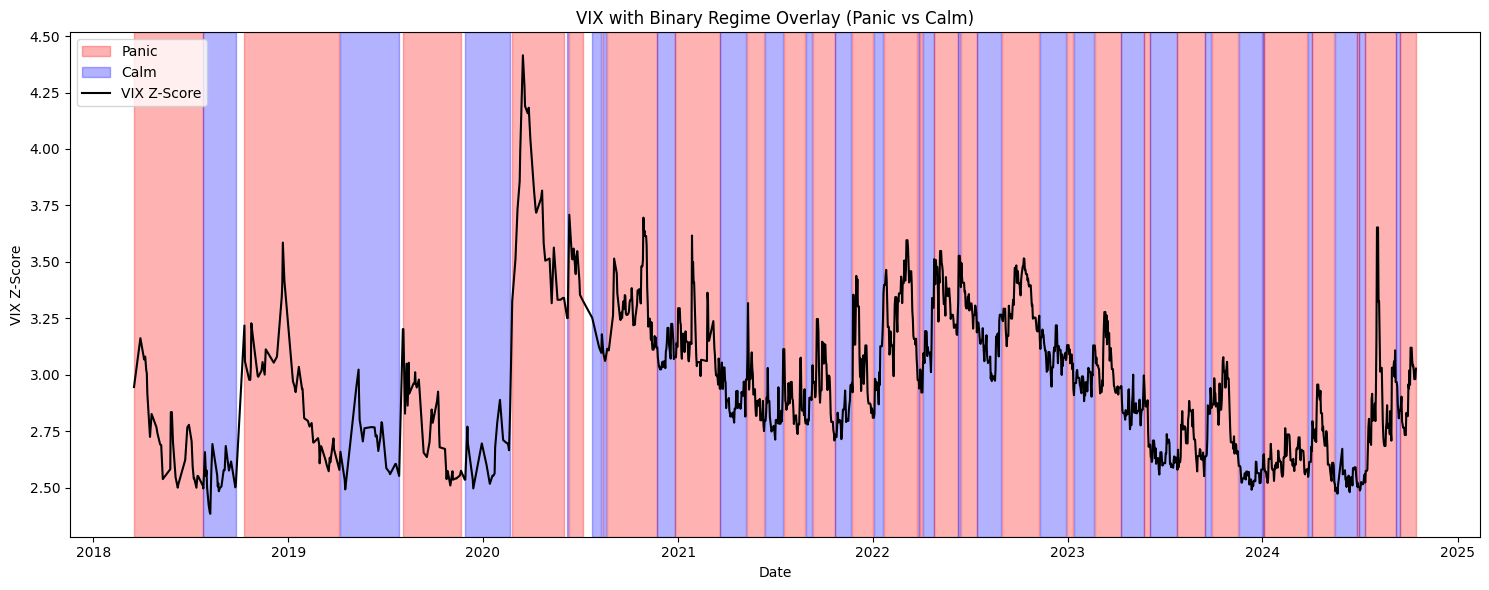

In [2924]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 6))
plt.plot(df_model.index, df_model['vix_target'], label='VIX_t', color='black')

# Efficient binary shading
start_idx = None
current_regime = None

for i in range(len(df_model)):
    regime = df_model['regime_t'].iloc[i]
    
    if regime != current_regime:
        if current_regime is not None:
            # Draw previous span
            plt.axvspan(df_model.index[start_idx], df_model.index[i - 1],
                        color='red' if current_regime == 1 else 'blue', alpha=0.3)
        # Start new span
        start_idx = i
        current_regime = regime

# Draw last span
if current_regime is not None:
    plt.axvspan(df_model.index[start_idx], df_model.index[-1],
                color='red' if current_regime == 1 else 'blue', alpha=0.3)

# Legend and labels
panic_patch = mpatches.Patch(color='red', alpha=0.3, label='Panic')
calm_patch = mpatches.Patch(color='blue', alpha=0.3, label='Calm')
plt.legend(handles=[panic_patch, calm_patch, plt.Line2D([], [], color='black', label='VIX Z-Score')])

plt.title('VIX with Binary Regime Overlay (Panic vs Calm)')
plt.xlabel('Date')
plt.ylabel('VIX Z-Score')
plt.tight_layout()
plt.show()


In [2925]:
df_model.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,regime_t+1,regime_t+1_raw
date,,,,,,,,,,,,,,,,,,,,,
2024-10-11,-0.313376,-0.972448,58,-0.157393,-0.971905,57,48,-0.235385,-0.972176,104,...,0.501729,18.034666,18.034666,18.030169,1.283896,0.003503,0.065116,1,1.0,0.122250
2024-10-12,0.181630,-0.959148,9,0.054226,-0.946041,31,6,0.117928,-0.952595,59,...,0.211239,18.127000,18.127000,18.036416,1.242025,0.072932,0.122250,1,1.0,0.245281
2024-10-13,-0.280690,-0.969393,10,-0.232838,-0.916358,12,8,-0.256764,-0.942875,22,...,0.204007,18.214666,18.214666,18.047916,1.202117,0.138714,0.245281,1,1.0,0.495994
2024-10-14,0.009047,-0.974299,24,-0.044218,-0.972195,43,20,-0.017585,-0.973247,82,...,0.197043,18.319333,18.319333,18.065427,1.164669,0.218007,0.495994,1,1.0,0.787314
2024-10-15,-0.242439,-0.975493,63,-0.210137,-0.972273,74,56,-0.226288,-0.973883,141,...,0.556791,18.404667,18.404667,18.087313,1.129657,0.280929,0.787314,1,NaN,NaN


In [2926]:
df_model = df_model.dropna()

In [2927]:
clf, y_pred, classification_df = macro_utils.clf_panic_tomorrow(df_model, selected_features, 'regime_t+1')

              precision    recall  f1-score   support

         0.0       0.98      0.09      0.17       636
         1.0       0.65      1.00      0.78      1055

    accuracy                           0.66      1691
   macro avg       0.81      0.55      0.48      1691
weighted avg       0.77      0.66      0.55      1691



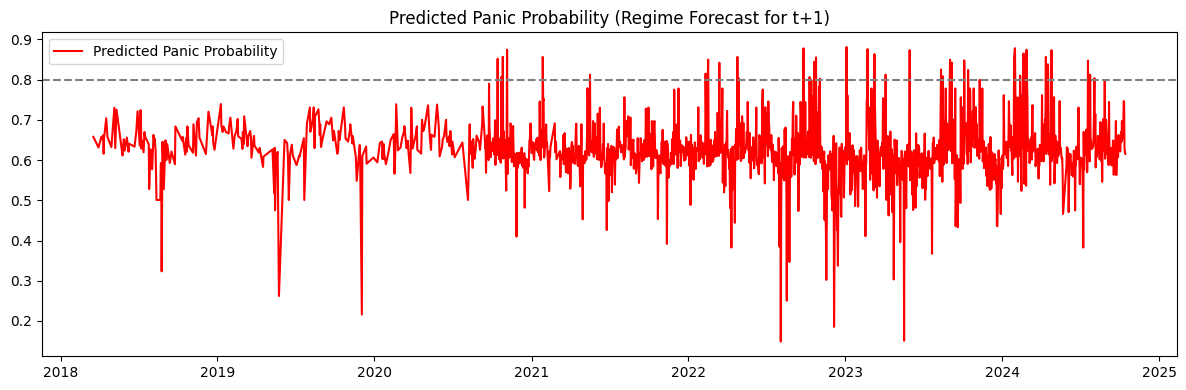

In [2928]:
plt.figure(figsize=(12, 4))
plt.plot(df_model.index, df_model['panic_prob'], label='Predicted Panic Probability', color='red')
plt.axhline(0.8, linestyle='--', color='gray')
plt.title("Predicted Panic Probability (Regime Forecast for t+1)")
plt.legend()
plt.tight_layout()
plt.show()


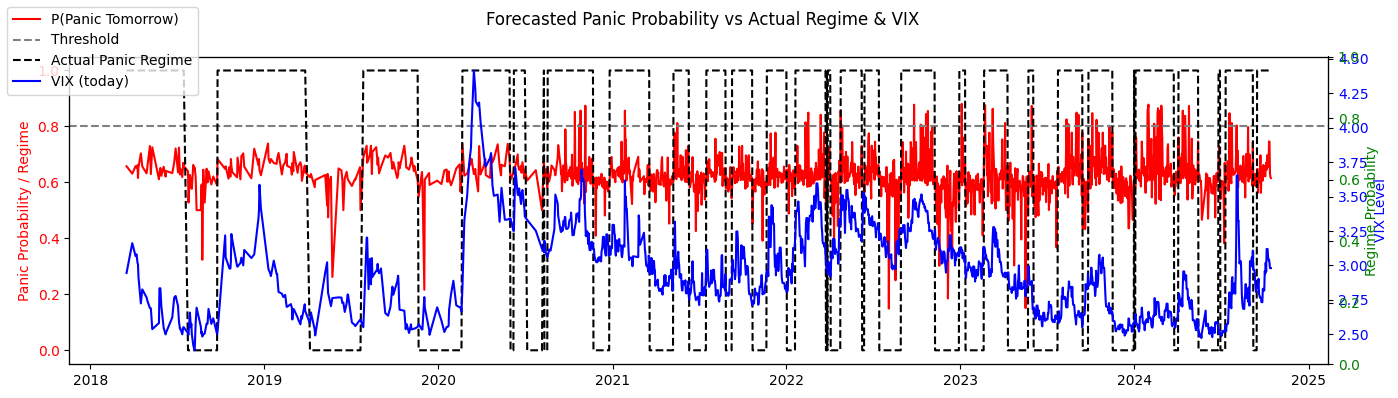

In [2929]:
fig, ax1 = plt.subplots(figsize=(14, 4)) #GOLD. panic regime probability goes up before vix even spikes. probability of panic tomorrow from classifier is high.

# Panic probability
ax1.plot(classification_df.index, classification_df['panic_prob'], label='P(Panic Tomorrow)', color='red')
ax1.axhline(0.8, linestyle='--', color='gray', label='Threshold')
ax1.plot(classification_df.index, classification_df['regime_t+1'], linestyle='--', color='black', label='Actual Panic Regime')
ax1.set_ylabel("Panic Probability / Regime", color='red')
ax1.tick_params(axis='y', labelcolor='red')

# Add second y-axis for VIX
ax2 = ax1.twinx()
ax2.plot(classification_df.index, classification_df['vix_target'], label='VIX (today)', color='blue')
ax2.set_ylabel("VIX Level", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

ax3 = ax1.twinx()
#ax3.plot(classification_df.index, classification_df['regime_t_raw'], label='Regime Probability', color='green')
ax3.set_ylabel("Regime Probability", color='green')
ax3.tick_params(axis='y', labelcolor='green')

fig.suptitle("Forecasted Panic Probability vs Actual Regime & VIX")
fig.tight_layout()
fig.legend(loc='upper left')
plt.show()
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
fig.autofmt_xdate()


for each regime=1, we now get the set of days aferwards to see how vix behaves as soon as the model changes regime

In [2930]:

classification_df = macro_utils.identify_sustained_regimes_and_transitions(classification_df)

In [2931]:
classification_df['is_transition'].value_counts()

is_transition
False    1663
True       28
Name: count, dtype: int64

In [2932]:
classification_df['regime_t']

date
2018-03-18    1
2018-03-30    1
2018-04-06    1
2018-04-08    1
2018-04-10    1
             ..
2024-10-10    1
2024-10-11    1
2024-10-12    1
2024-10-13    1
2024-10-14    1
Name: regime_t, Length: 1691, dtype: int64

In [2933]:

# Usage Example:
result = macro_utils.transform_vix_data(classification_df, window=60, k=2)
vix_windows_df_train = result["vix_windows_df_train"]
regime_windows_df_train = result["regime_windows_df_train"]
vix_windows_past_df_train = result["vix_windows_past_df_train"]


In [2934]:
regime_windows_df_train.shape

(26, 60)

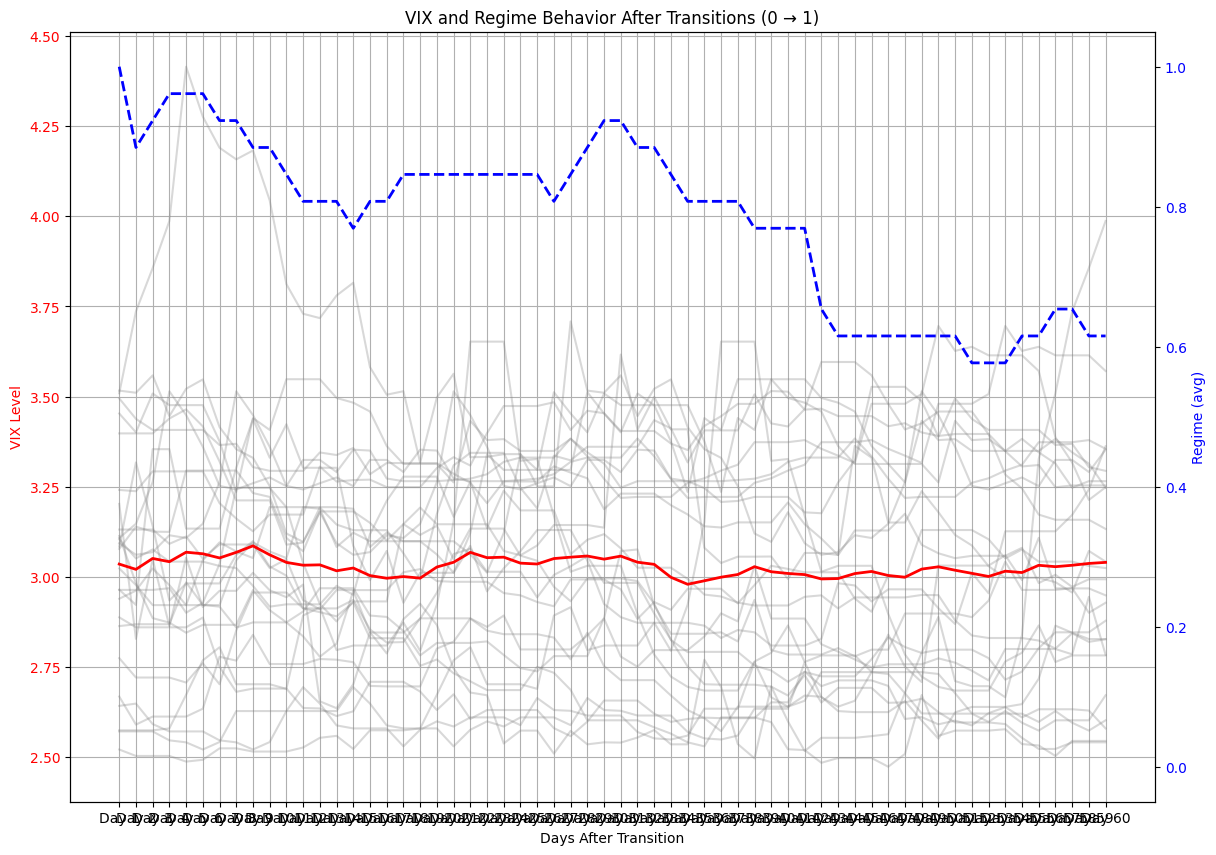

In [2935]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

# Primary axis: VIX transitions
ax1 = plt.gca()
ax1.plot(vix_windows_df_train.T, color="gray", alpha=0.3, label="Individual VIX transitions")
ax1.plot(vix_windows_df_train.mean(axis=0).values, color="red", linewidth=2, label="Mean VIX path")
ax1.set_xlabel("Days After Transition")
ax1.set_ylabel("VIX Level", color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_title("VIX and Regime Behavior After Transitions (0 → 1)")
ax1.grid(True)

# Secondary axis: Regime values
ax2 = ax1.twinx()
ax2.plot(regime_windows_df_train.mean(axis=0).values, color="blue", linewidth=2, linestyle="--", label="Mean Regime level")
ax2.set_ylabel("Regime (avg)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylim(-0.05, 1.05)  # Because regime is binary

# Combined legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
#plt.tight_layout()
plt.show()



since some spikes happen quite some time after the regime switches, we will build a classifier for 0 (immediate) or 1 (delayed), then feed this into a model for vix level forecasting

In [2936]:
vix_windows_past_df_train.tail()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-01-02,2.702032,2.700690,2.700690,2.700690,2.695303,2.670694,2.727199,2.651127,2.691921,2.691921,...,2.564180,2.564180,2.564180,2.564180,2.520113,2.523326,2.521721,2.580217,2.580217,2.580217
2024-01-05,2.700690,2.695303,2.670694,2.727199,2.651127,2.691921,2.691921,2.691921,2.650421,2.651833,...,2.564180,2.520113,2.523326,2.521721,2.580217,2.580217,2.580217,2.580217,2.641910,2.648300
2024-04-04,2.615204,2.615204,2.569554,2.551786,2.548664,2.559550,2.634045,2.634045,2.634045,2.763170,...,2.579459,2.583243,2.547881,2.565718,2.613739,2.613739,2.613739,2.613739,2.681706,2.662355
2024-06-27,2.829678,2.829678,2.753024,2.770712,2.732418,2.710048,2.685805,2.685805,2.685805,2.750471,...,2.545531,2.509599,2.586259,2.586259,2.580217,2.590017,2.590017,2.590017,2.552565,2.529721
2024-07-12,2.601949,2.582487,2.564949,2.540814,2.529721,2.610070,2.610070,2.610070,2.596746,2.521721,...,2.487404,2.492379,2.524127,2.524127,2.515274,2.515274,2.515274,2.526528,2.553344,2.558777


In [2937]:
vix_windows_df_train.iloc[-1].max()

np.float64(3.6524747643078785)

In [2938]:
df_delayed_spike_prob, clf_delayed_spike_prob, vix_pct_change_lookback_df_train = macro_utils.clf_delayed_spike_prob(vix_windows_df_train, df_model, "vix_target")

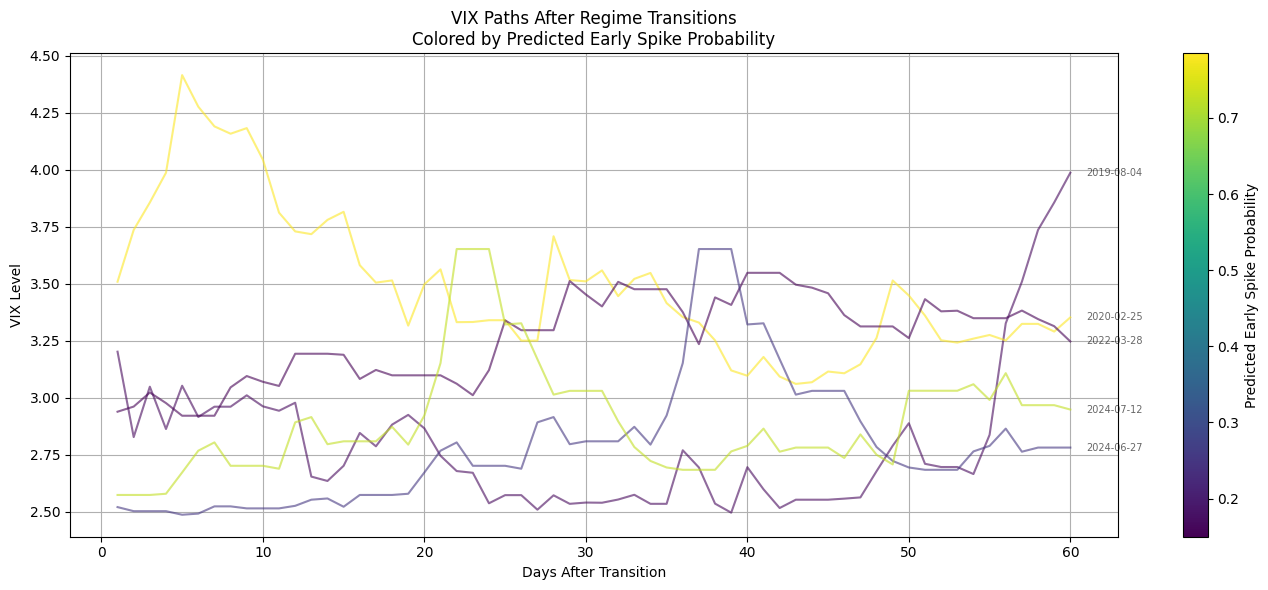

In [2939]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Filter rows with predictions
df_plot = df_delayed_spike_prob.dropna(subset=["early_spike_prob"])

# Normalize probs for coloring
probs = df_plot["early_spike_prob"]
colors = cm.viridis((probs - probs.min()) / (probs.max() - probs.min()))

fig, ax = plt.subplots(figsize=(14, 6))

# Plot VIX paths, colored by classifier probability
for i, (date, row) in enumerate(df_plot.iterrows()):
    vix_path = row.iloc[:60]  # assumes 60-day VIX columns are first
    ax.plot(range(1, 61), vix_path.values, color=colors[i], alpha=0.6)
    ax.text(61, vix_path.values[-1], date.strftime("%Y-%m-%d"), fontsize=7, alpha=0.6, va="center")

# Add colorbar
sm = ScalarMappable(cmap="viridis", norm=Normalize(vmin=probs.min(), vmax=probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Predicted Early Spike Probability")

# Labels and layout
ax.set_title("VIX Paths After Regime Transitions\nColored by Predicted Early Spike Probability")
ax.set_xlabel("Days After Transition")
ax.set_ylabel("VIX Level")
ax.grid(True)
plt.tight_layout()
plt.show()



In [2940]:
classification_df['regime_t'].value_counts()

regime_t
1    1055
0     636
Name: count, dtype: int64

We will now predict whether the regime switch is a spike or not

because of randomness, we will just predict peak, half decay time, and rising time.

In [2941]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news = train_df.copy()                       # original df you posted   # string/ts column → index
news = news.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()


    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats = engineer_news_feats(news)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats.index = pd.to_datetime(news_feats.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats.index.min(),
                          news_feats.index.max(),
                          freq='D')

news_dense = (
    news_feats
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)



/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/37269508.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .ffill()                 # carry last known sentiment forward


In [2942]:
train_df.head()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2018-03-18,-0.806745,-0.806745,1,0.048595,0.048595,1,0,-0.379075,-0.379075,1,...,0.374277,0.653030,16.731070,5.519739,0.414681,14.966207,14.966207,14.384143,5.398441,0.107821
2018-03-30,0.084789,0.084789,0,0.084558,0.084558,1,0,0.084673,0.084673,2,...,0.753526,1.318488,17.239888,5.620198,1.135211,15.101333,15.101333,14.437649,5.194454,0.127768
2018-04-06,0.091514,0.091514,0,0.065591,0.065591,1,0,0.078553,0.078553,2,...,0.241479,0.908250,17.550896,5.525650,0.712876,15.549334,15.549334,14.519759,5.005763,0.205678
2018-04-08,-0.896965,-0.896965,1,0.072943,0.072943,1,0,-0.412011,-0.412011,1,...,-0.416667,0.892227,17.856984,5.435833,0.719856,15.916000,15.916000,14.621931,4.831662,0.267831
2018-04-10,-0.525443,-0.638223,3,0.080863,0.068002,3,0,-0.222290,-0.285111,3,...,-0.200703,0.631611,18.045043,5.280167,0.459258,16.300000,16.300000,14.743671,4.672724,0.333067


In [2943]:
# ------------------------------------------------------------
# 3)  BUILD ARC-LEVEL TABLE  (robust to missing news dates + look-back stats)
# ------------------------------------------------------------
records = []
lookback_days = [2, 5, 7]
lookback_feats = [
    "shock_neg",
    "vix_zscore",
    "vix_target",
    "sentiment_dominance",

]

for dt, row in vix_windows_df_train.iterrows():
    # --- detect arc in the 60-day window ---
    v = row[[f"Day {i}" for i in range(1, 61)]].values
    r = regime_windows_df_train.loc[dt, [f"Day {i}" for i in range(1, 61)]].values
    start_idx, peak_idx = macro_utils.detect_spike_arc_within_regime(v, r)
    start_val, peak_val = v[start_idx], v[peak_idx]
    rise_dur = peak_idx - start_idx
    decay_idx = np.argmax(v[peak_idx:] < 0.5 * peak_val)
    half_life = decay_idx if decay_idx > 0 else len(v) - peak_idx

    dt_norm = pd.to_datetime(dt).normalize()

    # -------- safe fetch of nearest-past news features --------
    try:
        feats_on_start = news_dense.loc[:dt_norm].iloc[-1].to_dict()
    except IndexError:
        # no prior news available – skip this arc
        continue

    # -------- compute look-back statistics from classification_df --------
    lookback_stats = {}
    for w in lookback_days:
        start_date = dt_norm - pd.Timedelta(days=w)
        window_df = classification_df.loc[start_date:dt_norm]

        for feat in lookback_feats:
            col_mean = window_df[feat].mean()
            col_std = window_df[feat].std()
            # percent change over the window: (last−first) / first
            if len(window_df) > 1 and window_df[feat].iloc[0] != 0:
                col_pct = (window_df[feat].iloc[-1] - window_df[feat].iloc[0]) / window_df[feat].iloc[0]
            else:
                col_pct = np.nan

            lookback_stats[f"{feat}_mean_{w}d"] = col_mean
            lookback_stats[f"{feat}_std_{w}d"]  = col_std
            lookback_stats[f"{feat}_pctchg_{w}d"] = col_pct

    # --- aggregate everything into one record ---
    records.append({
        "date_start":    dt_norm,
        "peak_vix":      peak_val,
        "vix0":          start_val,
        "T_up":          rise_dur,
        "T_half":        half_life,
        **feats_on_start,
        **lookback_stats,
    })

arc_df = (
    pd.DataFrame(records)
      .set_index("date_start")
      .astype(float, errors="ignore")
)

print("arc_df shape:", arc_df.shape)

arc_df shape: (26, 68)


In [2944]:
arc_df['early_spike_prob'] = vix_windows_df_train['early_spike_prob'].fillna(0.5)

In [2945]:
arc_df = arc_df.dropna()

In [2946]:
arc_df = arc_df.drop(columns=['vix_target'])

In [2947]:
len(arc_df)

22

In [2948]:
arc_df['delta_peak'] = arc_df['peak_vix'] - arc_df['vix0']
arc_df['spike5d'] = (arc_df['delta_peak'] > 0.1 * arc_df['vix0']).astype(int)

In [3146]:
# ============================================================
# 0)  CONFIG & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_absolute_error

# --- your DataFrame and columns ---
# arc_df: pandas DataFrame already in scope
target_cols  = ["peak_vix", "T_up", "T_half", "delta_peak", 'spike5d']
feature_cols = arc_df.columns.difference(target_cols)
X_full       = arc_df[feature_cols].values
y_full       = arc_df[target_cols].values

# --- CV and scoring setup ---
tscv       = TimeSeriesSplit(n_splits=10)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# ============================================================
# 1)  HYPERPARAMETER GRIDS
# ============================================================
param_grid_default = {
    "mlp__hidden_layer_sizes": [(10, 5), (20, 10), (15, 10), (12, 8), (16, 10)],
    "mlp__alpha":              [0.1, 1.0, 10.0, 1.5, 1.9, 1.8, 1.7, 1.6, 1.4, 1.3, 1.2, 1.1],
    "mlp__learning_rate_init": [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 0.005, 0.0005],
}
param_grid_delta = {
    "mlp__hidden_layer_sizes": [(10, 5), (20, 10), (15, 10), (12, 8), (16, 10)],
    "mlp__alpha":              [0.1, 1.0, 10.0, 1.5, 1.9, 1.8, 1.7, 1.6, 1.4, 1.3, 1.2, 1.1],
    "mlp__learning_rate_init": [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 0.005, 0.0005],
}

models = {}
cv_mae = {}

# ============================================================
# 2)  GRID-SEARCH + FINAL FIT PER TARGET
# ============================================================
for col in target_cols:
    y = y_full[:, target_cols.index(col)]
    is_delta = (col == "delta_peak")

    # 2a) base pipeline: scale X → MLP
    base_pipe = Pipeline([
        ("scale_X", StandardScaler()),
        ("mlp", MLPRegressor(
            solver="adam",
            activation="tanh",
            max_iter=10000,
            random_state=38
        ))
    ])

    # 2b) wrap with a QuantileTransformer on y
    pipe = TransformedTargetRegressor(
        regressor=base_pipe,
        transformer=QuantileTransformer(
            n_quantiles=10,
            output_distribution="normal",
            random_state=38
        )
    )

    # 2c) GridSearchCV over the inner regressor
    grid = GridSearchCV(
        estimator=pipe.regressor,
        param_grid=(param_grid_delta if is_delta else param_grid_default),
        cv=tscv,
        scoring=mae_scorer,
        n_jobs=-1,
        verbose=1
    )

    # 2d) wrap back into TransformedTargetRegressor
    grid_pipe = TransformedTargetRegressor(
        regressor=grid,
        transformer=pipe.transformer
    )

    # run the grid-search
    print(f"\n>>> Grid‐searching hyperparams for '{col}' …")
    grid_pipe.fit(X_full, y)

    # pull tuned hyperparameters & CV score from the fitted GridSearchCV
    best_params = grid_pipe.regressor_.best_params_
    best_score  = grid_pipe.regressor_.best_score_
    print(f"Best params for {col}: {best_params}")
    print(f"Best CV MAE (10‐fold avg): {-best_score:.3f}")

    # 2e) build final model on all data using best_params
    print(f"Fitting final '{col}' model on all data …")
    mlp_kwargs = {k.replace("mlp__", ""): v for k, v in best_params.items()}
    final_pipe = TransformedTargetRegressor(
        regressor=Pipeline([
            ("scale_X", StandardScaler()),
            ("mlp", MLPRegressor(
                **mlp_kwargs,
                solver="adam",
                activation="tanh",
                max_iter=10000,
                random_state=38
            ))
        ]),
        transformer=pipe.transformer
    )
    final_pipe.fit(X_full, y)
    models[col] = final_pipe

    # quick CV to report final MAE
    perf = -np.mean(
        cross_validate(
            final_pipe, X_full, y,
            cv=tscv,
            scoring=mae_scorer,
            return_train_score=False,
            n_jobs=-1
        )["test_score"]
    )
    cv_mae[col] = perf
    print(f"{col:12s} | Final MAE (10-fold): {perf:.3f}")

    # save the trained pipeline
    joblib.dump(final_pipe, f"mlp_{col}.pkl")

# ============================================================
# 3)  SUMMARY
# ============================================================
print("\nSaved models:", list(models.keys()))
print("CV MAEs:", cv_mae)




>>> Grid‐searching hyperparams for 'peak_vix' …
Fitting 10 folds for each of 720 candidates, totalling 7200 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the envir

Best params for peak_vix: {'mlp__alpha': 1.8, 'mlp__hidden_layer_sizes': (15, 10), 'mlp__learning_rate_init': 0.3}
Best CV MAE (10‐fold avg): 0.931
Fitting final 'peak_vix' model on all data …
peak_vix     | Final MAE (10-fold): 0.290

>>> Grid‐searching hyperparams for 'T_up' …
Fitting 10 folds for each of 720 candidates, totalling 7200 fits


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (2). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(


Best params for T_up: {'mlp__alpha': 10.0, 'mlp__hidden_layer_sizes': (10, 5), 'mlp__learning_rate_init': 1.0}
Best CV MAE (10‐fold avg): 1.620
Fitting final 'T_up' model on all data …
T_up         | Final MAE (10-fold): 11.229

>>> Grid‐searching hyperparams for 'T_half' …
Fitting 10 folds for each of 720 candidates, totalling 7200 fits


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (2). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(


Best params for T_half: {'mlp__alpha': 10.0, 'mlp__hidden_layer_sizes': (20, 10), 'mlp__learning_rate_init': 0.3}
Best CV MAE (10‐fold avg): 1.709
Fitting final 'T_half' model on all data …
T_half       | Final MAE (10-fold): 13.433

>>> Grid‐searching hyperparams for 'delta_peak' …
Fitting 10 folds for each of 720 candidates, totalling 7200 fits


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (2). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(


Best params for delta_peak: {'mlp__alpha': 1.6, 'mlp__hidden_layer_sizes': (20, 10), 'mlp__learning_rate_init': 0.3}
Best CV MAE (10‐fold avg): 1.041
Fitting final 'delta_peak' model on all data …
delta_peak   | Final MAE (10-fold): 0.285

>>> Grid‐searching hyperparams for 'spike5d' …
Fitting 10 folds for each of 720 candidates, totalling 7200 fits


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (2). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(


Best params for spike5d: {'mlp__alpha': 1.3, 'mlp__hidden_layer_sizes': (16, 10), 'mlp__learning_rate_init': 1.0}
Best CV MAE (10‐fold avg): 3.090
Fitting final 'spike5d' model on all data …
spike5d      | Final MAE (10-fold): 0.200

Saved models: ['peak_vix', 'T_up', 'T_half', 'delta_peak', 'spike5d']
CV MAEs: {'peak_vix': np.float64(0.29041173963932165), 'T_up': np.float64(11.228830129349344), 'T_half': np.float64(13.43282707864606), 'delta_peak': np.float64(0.28513015966859817), 'spike5d': np.float64(0.2)}


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (2). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (4). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (6). n_quantiles is set to n_samples.
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (10) is greater than the total number of samples (8). n_quantiles is set to n_samples.
  warnings.warn(


In [3147]:
arc_df

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d,early_spike_prob,delta_peak,spike5d
date_start,,,,,,,,,,,,,,,,,,,,,
2020-08-11,3.093313,3.093313,0.0,60.0,0.050000,0.050000,0.0,0.089418,0.089418,2.0,...,-0.134013,3.132132,0.042470,0.018955,0.666667,1.527525,1.000000,0.5000,0.000000,0
2020-12-27,3.616578,3.077312,30.0,30.0,-0.026375,-0.969492,34.0,-0.086840,-0.973090,130.0,...,-1.207826,3.136046,0.069202,-0.045870,154.500000,57.435678,-0.321678,0.5000,0.539265,1
2021-05-10,3.317453,3.083743,1.0,59.0,0.102125,-0.952838,34.0,-0.066393,-0.966891,45.0,...,0.467499,2.936439,0.057206,0.024468,18.125000,11.444743,-0.275862,0.5000,0.233710,0
2021-07-18,3.075929,3.113515,31.0,29.0,-0.178163,-0.944129,4.0,-0.082068,-0.965580,7.0,...,-8.415142,2.896933,0.140425,0.118699,13.375000,10.225144,-0.600000,0.5000,-0.037586,0
2021-09-10,3.246880,2.963726,7.0,53.0,0.002707,-0.975736,76.0,-0.056710,-0.969297,228.0,...,-6.145282,2.906814,0.067145,0.087297,70.000000,48.414874,3.600000,0.5000,0.283154,0
2021-11-22,3.437851,2.964242,8.0,52.0,0.028002,-0.974339,66.0,-0.042103,-0.962845,189.0,...,9.402029,2.881325,0.066609,0.053730,26.750000,39.401777,-41.000000,0.5000,0.473609,1
2022-01-21,3.595941,3.317453,8.0,18.0,-0.249692,-0.975070,10.0,-0.177979,-0.961657,17.0,...,18.645145,3.154472,0.116074,0.138005,3.750000,6.017831,0.250000,0.5000,0.278488,0
2022-03-28,2.939162,2.939162,0.0,60.0,-0.155818,-0.974461,257.0,-0.073596,-0.972532,449.0,...,-0.116508,3.061709,0.081448,-0.057379,95.000000,45.791453,0.192661,0.1500,0.000000,0
2022-03-30,3.045950,3.023347,5.0,55.0,-0.181727,-0.973654,318.0,-0.171655,-0.971824,448.0,...,-0.084210,3.012917,0.073706,-0.062759,88.750000,37.193509,-0.084746,0.5000,0.022603,0


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


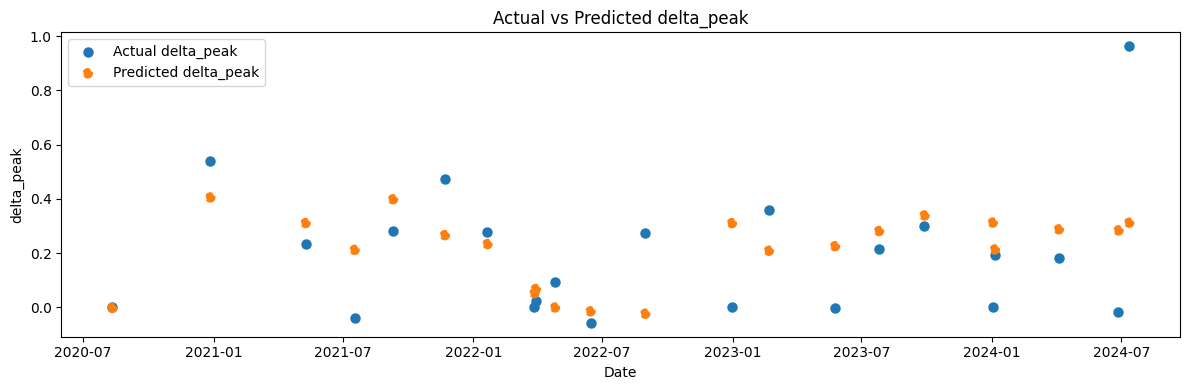

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


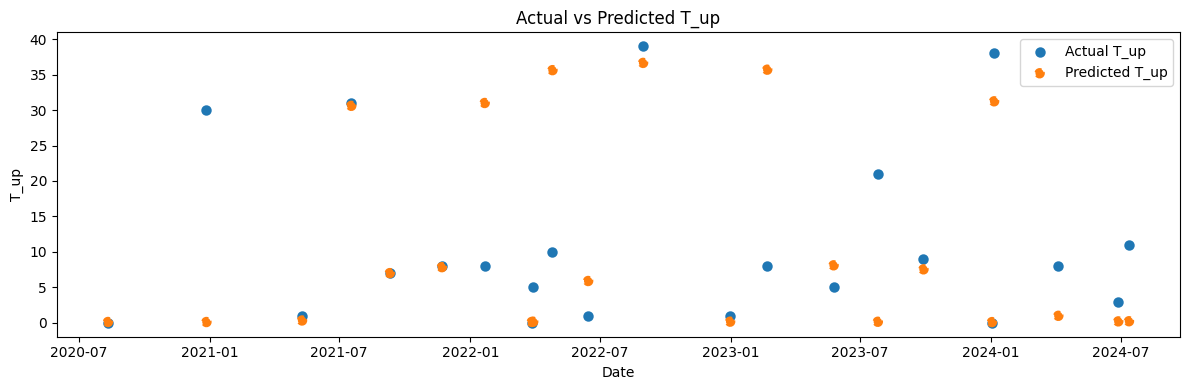

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


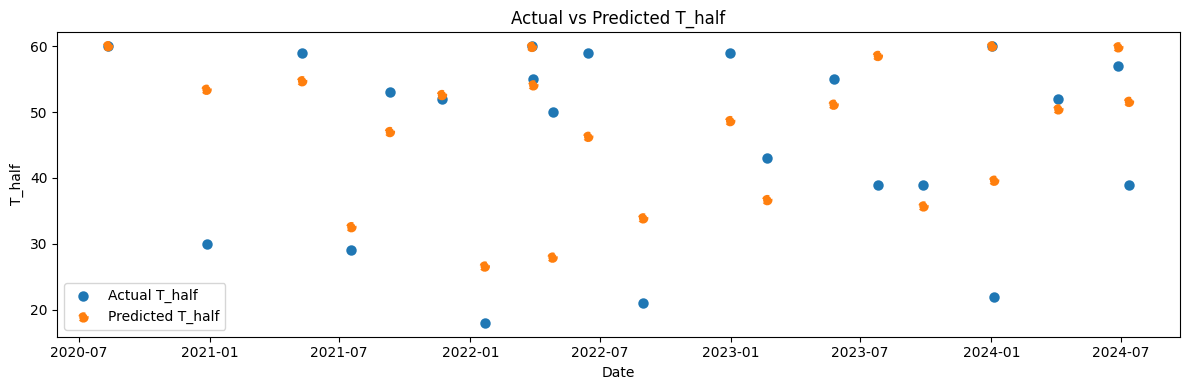

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


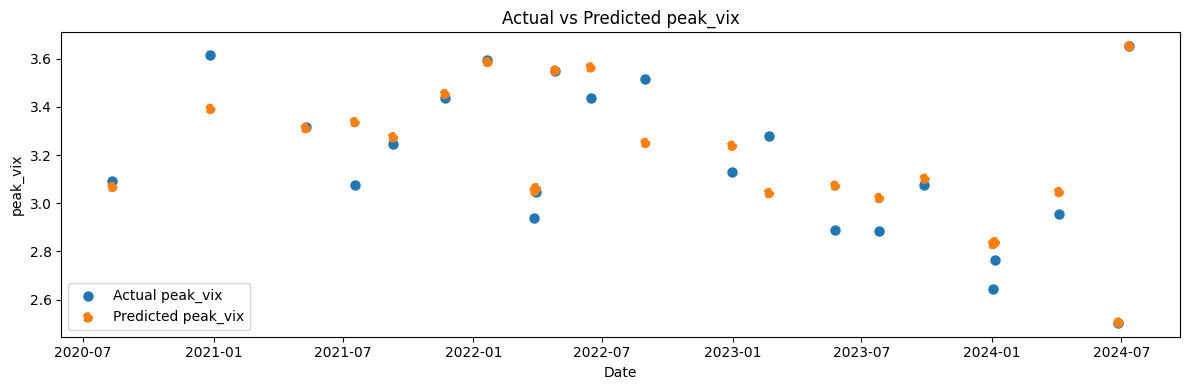

In [3148]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df.columns.difference(["delta_peak", "T_up", "T_half", 'peak_vix', 'spike5d'])

X_full_test = arc_df.reindex(columns=feature_cols)
X_full_test = X_full_test.fillna(0)

dates = arc_df.index         # x‑axis

models = {
    "delta_peak": joblib.load("mlp_delta_peak.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
}

for target, model in models.items():
    y_true_test = arc_df[target].values
    y_pred_test = model.predict(X_full_test)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true_test, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred_test, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [3149]:
import pandas as pd

# 1) Prepare your inputs & models (as you already have)
feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half", "delta_peak", 'spike5d'])
X_full       = arc_df[feature_cols].values
dates        = arc_df.index

models = {
    "peak_vix":   joblib.load("mlp_peak_vix.pkl"),
    "T_up":       joblib.load("mlp_T_up.pkl"),
    "T_half":     joblib.load("mlp_T_half.pkl"),
    "delta_peak": joblib.load("mlp_delta_peak.pkl"),
}

# 2) Build the predictions DataFrame
pred_df = pd.DataFrame(index=dates)

for target, model in models.items():
    y_pred = model.predict(X_full)
    pred_df[f"nn_{target}"] = y_pred

# 3) (Optional) peek at the first few rows
print(pred_df.head())

# 4) (Optional) join back to your original DataFrame
arc_df_with_nn = arc_df.join(pred_df)


            nn_peak_vix    nn_T_up  nn_T_half  nn_delta_peak
date_start                                                  
2020-08-11     3.067358   0.124301  59.996426      -0.001565
2020-12-27     3.391844   0.120566  53.379613       0.405686
2021-05-10     3.311935   0.337736  54.676942       0.311203
2021-07-18     3.336790  30.591976  32.526267       0.212452
2021-09-10     3.274231   7.013376  46.963765       0.398775


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


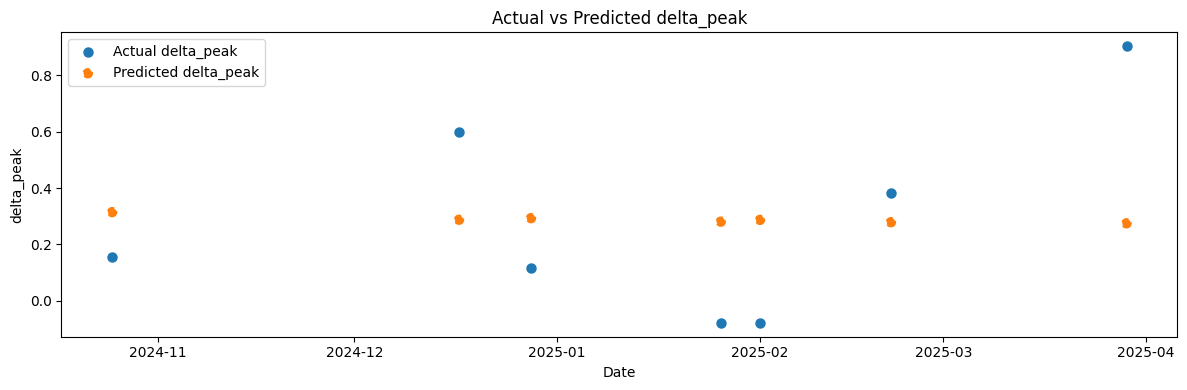

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


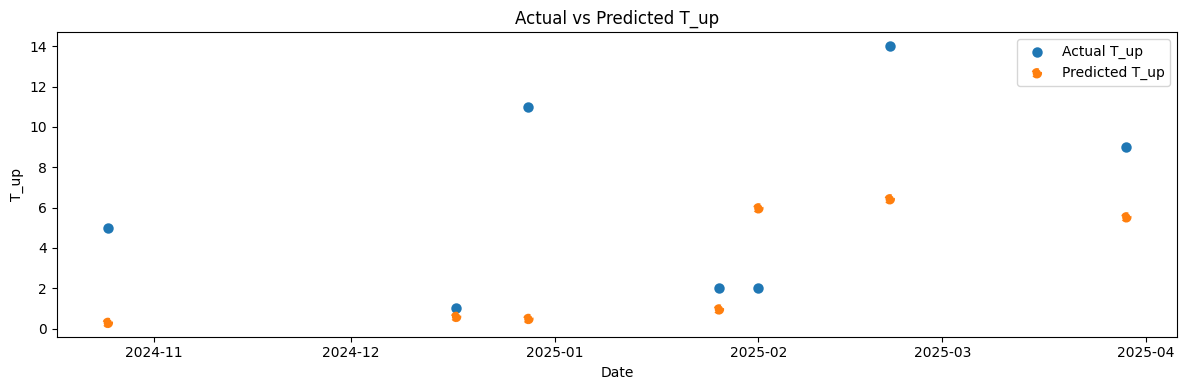

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


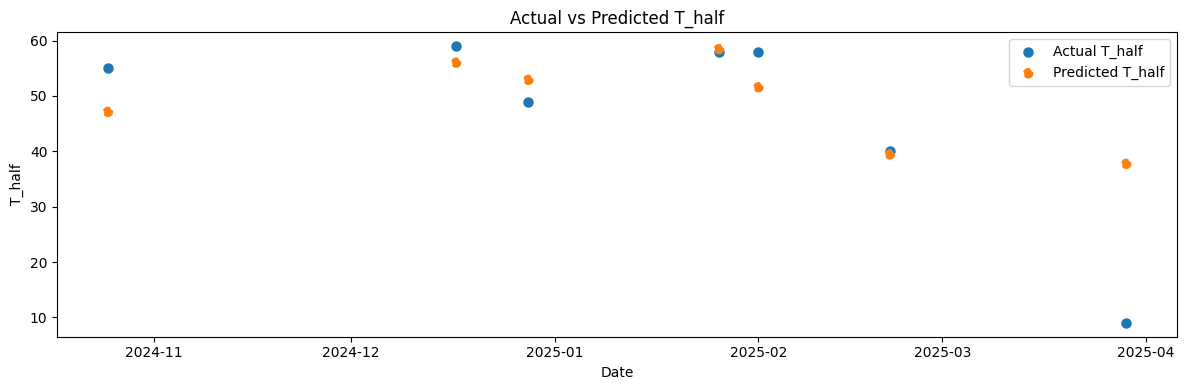

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


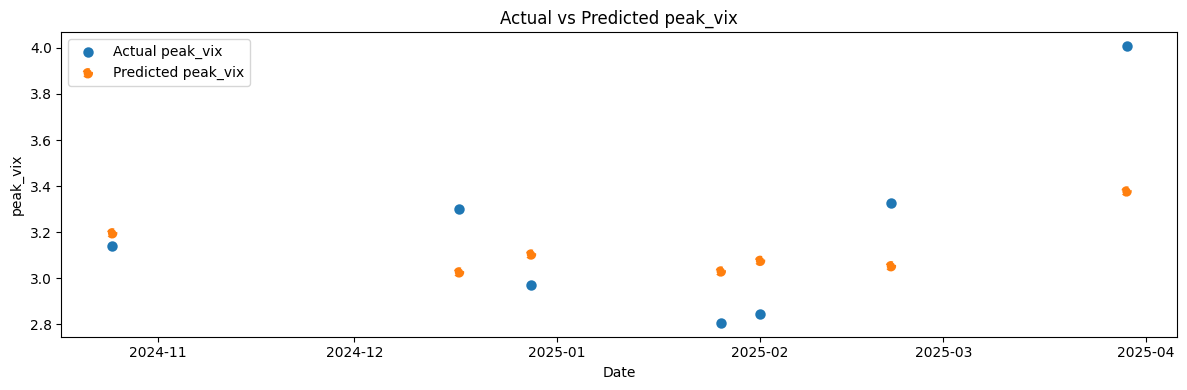

In [3150]:
import joblib, matplotlib.pyplot as plt

feature_cols = arc_df.columns.difference(["delta_peak", "T_up", "T_half", 'peak_vix', 'spike5d'])

X_full_test = arc_df_test.reindex(columns=feature_cols)
X_full_test = X_full_test.fillna(0)

dates = arc_df_test.index         # x‑axis

models = {
    "delta_peak": joblib.load("mlp_delta_peak.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
}

pred_df_test = pd.DataFrame(index=dates)


# 4) (Optional) join back to your original DataFrame
arc_df_with_nn = arc_df.join(pred_df)

for target, model in models.items():
    y_true_test = arc_df_test[target].values
    y_pred_test = model.predict(X_full_test)
    pred_df_test[f"nn_{target}"] = y_pred_test


    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true_test, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred_test, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [3151]:
pred_df_test.tail()
arc_df_with_nn_test = arc_df_test.join(pred_df_test)


In [3152]:
arc_df_with_nn_test.tail()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d,early_spike_prob,delta_peak,spike5d,nn_delta_peak,nn_T_up,nn_T_half,nn_peak_vix
date_start,,,,,,,,,,,,,,,,,,,,,
2024-12-28,2.972464,2.856470,11.0,49.0,-0.066260,-0.975939,19.0,0.046485,-0.964535,66.0,...,39.375,15.042203,0.138889,0.500,0.115994,0,0.293002,0.480898,52.916033,3.103572
2025-01-26,2.806990,2.884801,2.0,58.0,-0.191643,-0.971789,9.0,-0.085867,-0.854118,15.0,...,7.500,15.287717,NaN,0.500,-0.077811,0,0.280641,0.953018,58.468272,3.030033
2025-02-01,2.845491,2.924236,2.0,58.0,0.029324,-0.950893,11.0,-0.143875,-0.949542,20.0,...,-1.875,17.216583,0.500000,0.500,-0.078746,0,0.286985,5.963080,51.577965,3.076052
2025-02-21,3.327192,2.943386,14.0,40.0,-0.115498,-0.975739,49.0,-0.161775,-0.971196,74.0,...,29.750,17.458113,-0.519231,0.525,0.383806,1,0.278661,6.411851,39.455704,3.052761
2025-03-29,4.007333,3.103689,9.0,9.0,-0.108121,-0.975388,41.0,-0.056513,-0.963759,82.0,...,70.000,40.994773,0.304348,0.645,0.903644,1,0.274769,5.516683,37.742031,3.377169


because lack of data we narrow down feats

In [3153]:
target = "peak_vix"
correlations = arc_df[feature_cols].corrwith(arc_df[target]).abs().sort_values(ascending=False)
top_features = correlations.head(5).index.tolist()


In [3154]:
arc_df.corr()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d,early_spike_prob,delta_peak,spike5d
peak_vix,1.000000,0.683474,0.156983,-0.337761,0.252219,-0.047597,-0.142167,-0.032021,-0.053136,-0.030465,...,-0.150382,0.592922,0.420348,0.347101,-0.103506,0.170038,-0.198008,0.494140,0.590548,0.418652
vix0,0.683474,1.000000,-0.046987,-0.036669,0.282984,0.108855,0.089446,-0.226787,0.098278,0.183471,...,-0.329287,0.926619,0.744846,0.484709,-0.092451,0.286837,0.191791,0.100248,-0.185467,-0.175525
T_up,0.156983,-0.046987,1.000000,-0.833689,-0.372714,-0.192704,-0.225182,0.040815,-0.206835,-0.289161,...,-0.011434,-0.062014,0.072458,0.072427,-0.105254,0.033627,-0.049621,0.215668,0.263266,0.094401
T_half,-0.337761,-0.036669,-0.833689,1.000000,0.518729,0.219085,0.291814,0.068089,0.226076,0.369445,...,-0.145413,-0.000812,-0.142339,-0.233551,0.220666,0.101589,0.025178,-0.297593,-0.414136,-0.210146
summary_mean,0.252219,0.282984,-0.372714,0.518729,1.000000,0.226913,-0.102338,0.499709,0.228786,0.131917,...,-0.229517,0.114057,-0.017948,0.029553,0.108880,0.115568,-0.188686,0.220262,0.026678,-0.115045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sentiment_dominance_std_7d,0.170038,0.286837,0.033627,0.101589,0.115568,-0.284332,0.593832,0.011753,-0.283120,0.738880,...,0.137293,0.402944,0.183849,-0.156806,0.396478,1.000000,0.097890,-0.113242,-0.088209,0.084712
sentiment_dominance_pctchg_7d,-0.198008,0.191791,-0.049621,0.025178,-0.188686,0.099634,0.118575,-0.168892,0.090814,0.054231,...,-0.165668,0.264581,0.155687,0.014739,0.191100,0.097890,1.000000,-0.208770,-0.478575,-0.491149
early_spike_prob,0.494140,0.100248,0.215668,-0.297593,0.220262,0.039638,-0.451900,0.317526,0.045940,-0.395730,...,-0.020638,-0.086411,-0.076629,0.307992,-0.372495,-0.113242,-0.208770,1.000000,0.554358,0.330819
delta_peak,0.590548,-0.185467,0.263266,-0.414136,0.026678,-0.184413,-0.290261,0.207614,-0.180177,-0.243841,...,0.161599,-0.226239,-0.257593,-0.068608,-0.037127,-0.088209,-0.478575,0.554358,1.000000,0.757611


In [3155]:
print(top_features)

['vix0', 'vix_target_mean_2d', 'vix_target_mean_5d', 'vix_target_mean_7d', 'early_spike_prob']


In [3156]:
top_features.append('sentiment_dominance_std_7d')
top_features.append('headline_min')
top_features.append('shock_neg_std_5d')


# XGBoost

In [3159]:
# ============================================================
# 0)  CONFIG & IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_absolute_error

from xgboost import XGBRegressor

# --- assume arc_df and top_features are already defined ---
#arc_df["delta_peak"] = arc_df["peak_vix"] - arc_df["vix0"]
target_cols = ["delta_peak"]
quantiles   = [0.10, 0.50, 0.90]

# --- base & quantile-specific params ---
base_xgb_params = {
    "learning_rate":    0.07,
    "subsample":        0.7,
    "colsample_bytree": 0.7,
    "random_state":     42,
    "gamma":            0.05,
}

# --- CV setup & scorer ---
tscv       = TimeSeriesSplit(n_splits=5)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# --- define a search grid for XGB ---
param_grid_xgb = {
    "xgb__n_estimators":    [50,120, 130, 140, 150, 160, 170, 180, 190, 200],
    "xgb__max_depth":       [2, 3],
    "xgb__learning_rate":   [0.01, 0.07, 0.1, 0.005],
    "xgb__subsample":       [0.5, 0.7, 1.0],
    "xgb__colsample_bytree":[0.5, 0.7, 1.0],
    "xgb__reg_alpha":       [0.0, 0.1, 0.5, 1.0],
    "xgb__reg_lambda":      [0.0, 0.5, 1.0],
    "xgb__gamma":           [0.0, 0.05, 0.1],
}

models = {}
cv_mae = {}

# ============================================================
# 1)  GRID-SEARCH + FINAL FIT FOR EACH TARGET & QUANTILE
# ============================================================
X_full = arc_df[top_features].values
y_full = arc_df[target_cols].values

for i, col in enumerate(target_cols):
    y = y_full[:, i]
    for q in quantiles:
        print(f"\n>>> Grid‐searching '{col}' at quantile {q:.2f}")

        # 1a) fixed quantile params
        fixed_params = base_xgb_params.copy()
        fixed_params.update({
            "objective":      "reg:quantileerror",
            "quantile_alpha": q
        })

        # 1b) pipeline: scale → XGB
        pipe = Pipeline([
            ("scale_X", StandardScaler()),
            ("xgb",      XGBRegressor(**fixed_params))
        ])

        # 1c) grid-search over other hyperparameters
        grid = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid_xgb,
            cv=tscv,
            scoring=mae_scorer,
            n_jobs=-1,
            verbose=1
        )
        grid.fit(X_full, y)

        # 1d) extract best params & CV score
        best_params = grid.best_params_
        best_score  = -grid.best_score_
        print(f"Best params for {col}@{q:.2f}: {best_params}")
        print(f"Best CV MAE: {best_score:.3f}")

        # 1e) re‐evaluate final MAE via CV
        final_mae = -np.mean(
            cross_validate(
                grid.best_estimator_, X_full, y,
                cv=tscv,
                scoring=mae_scorer,
                n_jobs=-1
            )["test_score"]
        )
        print(f"{col}@{q:.2f} | Final MAE (10-fold): {final_mae:.3f}")

        # 1f) save the best‐estimator
        models[(col, q)] = grid.best_estimator_
        joblib.dump(grid.best_estimator_, f"xgb_{col}_q{q:.2f}.pkl")

# ============================================================
# 2)  PREDICT FUNCTION WITH SPREAD (unchanged)
# ============================================================
def predict_new_arc(row_df: pd.DataFrame):
    preds = {}
    for col in target_cols:
        preds[col] = {}
        for q in quantiles:
            model = models[(col, q)]
            preds[col][q] = float(model.predict(row_df[top_features].values))
        preds[col]["spread"] = preds[col][quantiles[2]] - preds[col][quantiles[0]]
    return preds

print("\nDone. Models saved and CV MAEs recorded in cv_mae dict.")  



>>> Grid‐searching 'delta_peak' at quantile 0.10
Fitting 5 folds for each of 25920 candidates, totalling 129600 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Best params for delta_peak@0.10: {'xgb__colsample_bytree': 0.7, 'xgb__gamma': 0.05, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 190, 'xgb__reg_alpha': 0.5, 'xgb__reg_lambda': 0.0, 'xgb__subsample': 0.5}
Best CV MAE: 0.155
delta_peak@0.10 | Final MAE (10-fold): 0.155

>>> Grid‐searching 'delta_peak' at quantile 0.50
Fitting 5 folds for each of 25920 candidates, totalling 129600 fits
Best params for delta_peak@0.50: {'xgb__colsample_bytree': 1.0, 'xgb__gamma': 0.0, 'xgb__learning_rate': 0.07, 'xgb__max_depth': 2, 'xgb__n_estimators': 50, 'xgb__reg_alpha': 0.0, 'xgb__reg_lambda': 1.0, 'xgb__subsample': 1.0}
Best CV MAE: 0.184
delta_peak@0.50 | Final MAE (10-fold): 0.184

>>> Grid‐searching 'delta_peak' at quantile 0.90
Fitting 5 folds for each of 25920 candidates, totalling 129600 fits
Best params for delta_peak@0.90: {'xgb__colsample_bytree': 0.5, 'xgb__gamma': 0.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__reg_alpha': 0.0, '

            xgb_delta_peak_q0.10  xgb_delta_peak_q0.50  xgb_delta_peak_q0.90
date_start                                                                  
2020-08-11             -0.000398              0.073441              0.278489
2020-12-27              0.148861              0.481359              0.539266
2021-05-10              0.002473              0.233181              0.319348
2021-07-18             -0.043821              0.198780              0.271052
2021-09-10              0.034677              0.282143              0.339245


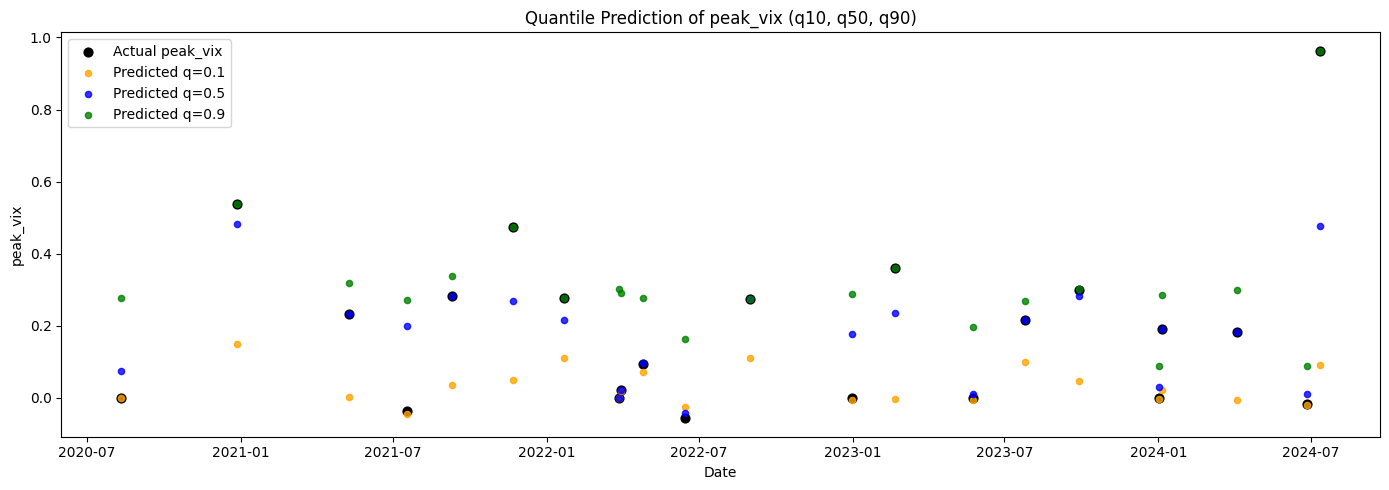

In [3160]:
import joblib
import matplotlib.pyplot as plt

# Load features and true values
feature_cols = arc_df.columns.difference(["delta_peak", "T_up", "T_half", 'peak_vix'])
X_full       = arc_df[top_features].values
dates        = arc_df.index
y_true       = arc_df["delta_peak"].values

# Load quantile models
models = {
    q: joblib.load(f"xgb_delta_peak_q{q:.2f}.pkl")
    for q in quantiles
}

# Get predictions
preds = {
    q: models[q].predict(X_full)
    for q in quantiles
}

for q in quantiles:
    model = joblib.load(f"xgb_delta_peak_q{q:.2f}.pkl")
    arc_df_with_nn[f"xgb_delta_peak_q{q:.2f}"] = model.predict(X_full)

# Now arc_df_with_nn has nn_… columns plus xgb_delta_peak_q0.10, 0.50, 0.90
print(arc_df_with_nn.filter(like='xgb_delta_peak').head())

# Plot
plt.figure(figsize=(14, 5))
plt.scatter(dates, y_true, label="Actual peak_vix", color="black", s=40)

# Plot quantile dots
colors = {quantiles[0]: "orange", quantiles[1]: "blue", quantiles[2]: "green"}
for q in quantiles:
    plt.scatter(dates, preds[q], label=f"Predicted q={q:.1f}", color=colors[q], s=20, alpha=0.8)

plt.title("Quantile Prediction of peak_vix (q10, q50, q90)")
plt.xlabel("Date")
plt.ylabel("peak_vix")
plt.legend()
plt.tight_layout()
plt.show()


            xgb_delta_peak_q0.10  xgb_delta_peak_q0.50  xgb_delta_peak_q0.90
date_start                                                                  
2024-10-25             -0.011051              0.220832              0.300272
2024-12-17              0.089357              0.048646              0.319089
2024-12-28             -0.006253              0.205022              0.310774
2025-01-26              0.003048              0.077843              0.341948
2025-02-01             -0.009447              0.087579              0.312362


/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Stand

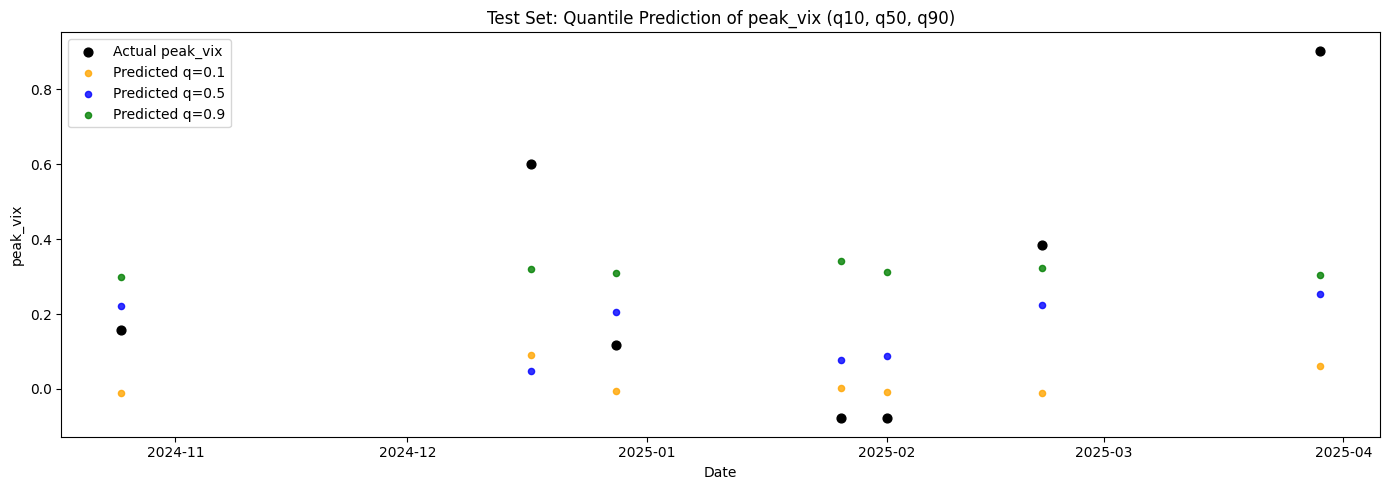

In [3161]:
import joblib
import matplotlib.pyplot as plt

# Load features and test dates
arc_df_test["delta_peak"] = arc_df_test["peak_vix"] - arc_df_test["vix0"]
feature_cols   = arc_df_test.columns.difference(["delta_peak", "T_up", "T_half", "peak_vix"])
X_full_test = arc_df_test.reindex(columns=top_features).fillna(0)
dates_test     = arc_df_test.index
y_true_test    = arc_df_test["delta_peak"].values

# Quantiles and color map
colors = {quantiles[0]: "orange", quantiles[1]: "blue", quantiles[2]: "green"}

# Load quantile models for peak_vix
models = {
    q: joblib.load(f"xgb_delta_peak_q{q:.2f}.pkl")
    for q in quantiles
}

# Predict for each quantile
preds_test = {
    q: models[q].predict(X_full_test)
    for q in quantiles
}

for q in quantiles:
    model = joblib.load(f"xgb_delta_peak_q{q:.2f}.pkl")
    arc_df_with_nn_test[f"xgb_delta_peak_q{q:.2f}"] = model.predict(X_full_test)

# Now arc_df_with_nn has nn_… columns plus xgb_delta_peak_q0.10, 0.50, 0.90
print(arc_df_with_nn_test.filter(like='xgb_delta_peak').head())

# Plot
plt.figure(figsize=(14, 5))
plt.scatter(dates_test, y_true_test, label="Actual peak_vix", color="black", s=40)

for q in quantiles:
    plt.scatter(dates_test, preds_test[q], label=f"Predicted q={q:.1f}", color=colors[q], s=20, alpha=0.8)

plt.title("Test Set: Quantile Prediction of peak_vix (q10, q50, q90)")
plt.xlabel("Date")
plt.ylabel("peak_vix")
plt.legend()
plt.tight_layout()
plt.show()


we will now do a final model that takes the inputs from the other models for a final output

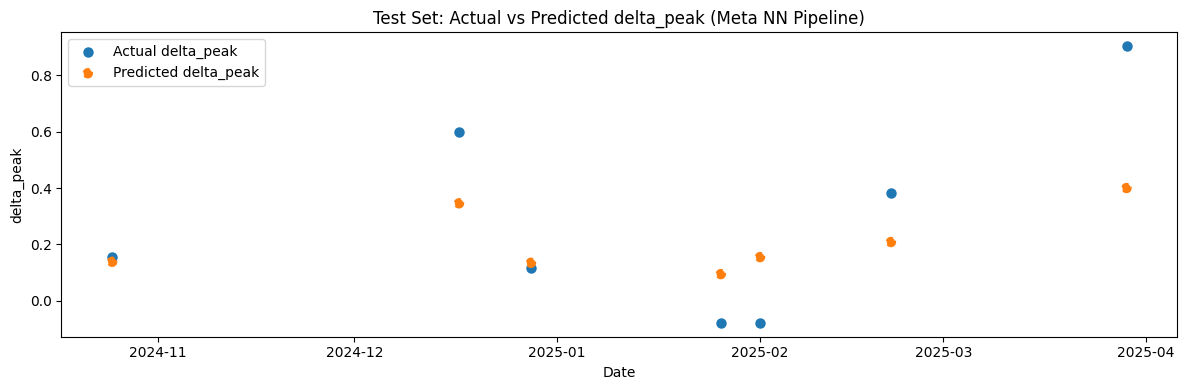

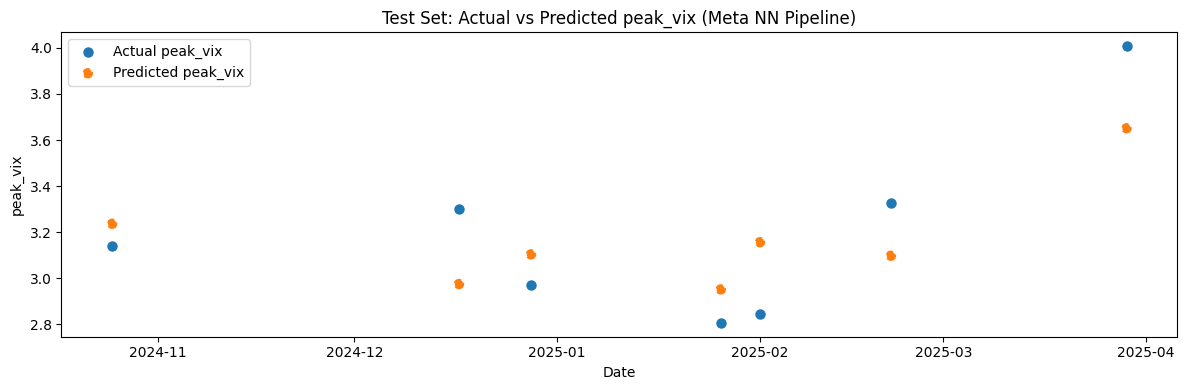

In [3327]:
# ============================================================
# Re-train & save your meta-models as full Pipelines
# (so scaling + NN are bundled together for both targets)
# ============================================================

import numpy as np
import pandas as pd
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# --- Assumes these DataFrames exist in your namespace:
#     • arc_df_with_nn       (training data with meta-features + true targets)
#     • arc_df_with_nn_test  (test data with same structure)

# --- 1) Define excluded columns and collect meta-features ---
excluded = {"peak_vix", "delta_peak", "T_up", "T_half"}

meta_features_delta = [
    col for col in arc_df_with_nn.columns
    if col not in excluded and (col.startswith("nn_") or col.startswith("xgb_delta_peak"))
]

meta_features_peak = [
    col for col in arc_df_with_nn.columns
    if col not in excluded and col.startswith("nn_")  # excludes nn_delta_peak
]

# --- 2) Build training matrices ---
X_meta_delta = arc_df_with_nn[meta_features_delta].values
y_delta      = arc_df_with_nn["delta_peak"].values

X_meta_peak  = arc_df_with_nn[meta_features_peak].values
y_peak       = arc_df_with_nn["peak_vix"].values

# --- 3) Define & train the delta_peak meta‐Pipeline ---
meta_delta_pipe = Pipeline([
    ("scale_meta", StandardScaler()),
    ("meta_nn",    MLPRegressor(
                       hidden_layer_sizes=(15, 26),
                       activation="tanh",
                       solver="adam",
                       max_iter=10000,
                       random_state=42,
                       alpha=0,
                       early_stopping=True
                   ))
])
meta_delta_pipe.fit(X_meta_delta, y_delta)
joblib.dump(meta_delta_pipe, "meta_delta_pipe.pkl")

# --- 4) Define & train the peak_vix meta‐Pipeline ---
meta_peak_pipe = Pipeline([
    ("scale_meta", StandardScaler()),
    ("meta_nn",    MLPRegressor(
                       hidden_layer_sizes=(19, 25),
                       activation="tanh",
                       solver="adam",
                       max_iter=10000,
                       random_state=42,
                       alpha=0.3,
                       early_stopping=True
                   ))
])
meta_peak_pipe.fit(X_meta_peak, y_peak)
joblib.dump(meta_peak_pipe, "meta_peak_pipe.pkl")

import matplotlib.pyplot as plt

# 5) Build test matrices
X_meta_delta_test = arc_df_with_nn_test[meta_features_delta].values
y_test_delta      = arc_df_with_nn_test["delta_peak"].values

X_meta_peak_test  = arc_df_with_nn_test[meta_features_peak].values
y_test_peak       = arc_df_with_nn_test["peak_vix"].values

dates_test = arc_df_with_nn_test.index

# 6) Load your full pipelines (with scaling & NN)
delta_pipe = joblib.load("meta_delta_pipe.pkl")
peak_pipe  = joblib.load("meta_peak_pipe.pkl")

# 7) Predict on test
y_pred_delta = delta_pipe.predict(X_meta_delta_test)
y_pred_peak  = peak_pipe.predict(X_meta_peak_test)

# 8a) Plot delta_peak
plt.figure(figsize=(12, 4))
plt.scatter(dates_test, y_test_delta, label="Actual delta_peak", linewidth=1.5)
plt.scatter(dates_test, y_pred_delta, label="Predicted delta_peak", linestyle="--", linewidth=1.5)
plt.title("Test Set: Actual vs Predicted delta_peak (Meta NN Pipeline)")
plt.xlabel("Date")
plt.ylabel("delta_peak")
plt.legend()
plt.tight_layout()
plt.show()

# 8b) Plot peak_vix
plt.figure(figsize=(12, 4))
plt.scatter(dates_test, y_test_peak, label="Actual peak_vix", linewidth=1.5)
plt.scatter(dates_test, y_pred_peak, label="Predicted peak_vix", linestyle="--", linewidth=1.5)
plt.title("Test Set: Actual vs Predicted peak_vix (Meta NN Pipeline)")
plt.xlabel("Date")
plt.ylabel("peak_vix")
plt.legend()
plt.tight_layout()
plt.show()


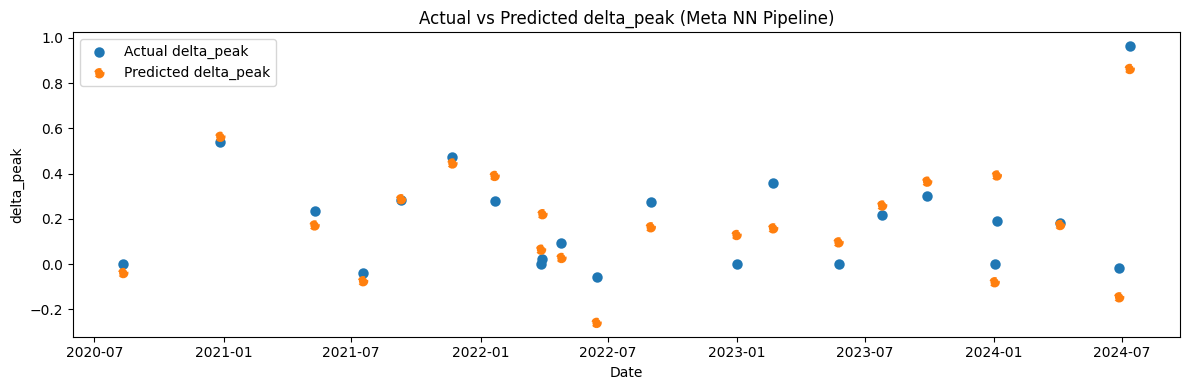

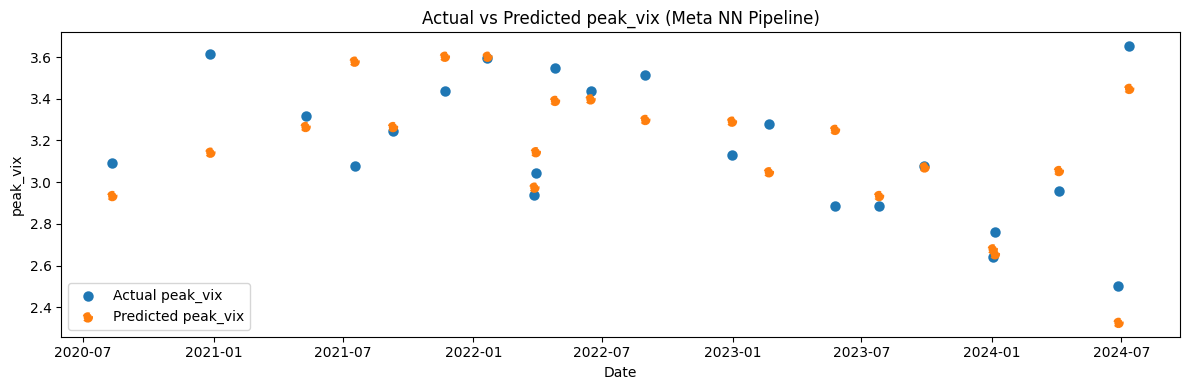

In [3329]:
# 1) EXACTLY the same meta‐feature lists as in training
excluded = {"peak_vix", "delta_peak", "T_up", "T_half"}

meta_features_delta = [
    col for col in arc_df_with_nn.columns
    if col not in excluded and (col.startswith("nn_") or col.startswith("xgb_delta_peak"))
]
meta_features_peak = [
    col for col in arc_df_with_nn.columns
    if col not in excluded and col.startswith("nn_")
]

# 2) Build X & y
dates        = arc_df_with_nn.index
X_meta_delta = arc_df_with_nn[meta_features_delta].values
y_true_delta = arc_df_with_nn["delta_peak"].values
X_meta_peak  = arc_df_with_nn[meta_features_peak].values
y_true_peak  = arc_df_with_nn["peak_vix"].values

# 3) Load the full pipelines you trained & saved
delta_pipe = joblib.load("meta_delta_pipe.pkl")
peak_pipe  = joblib.load("meta_peak_pipe.pkl")

# 4) Predict (scaling happens automatically inside the pipeline)
y_pred_delta = delta_pipe.predict(X_meta_delta)
y_pred_peak  = peak_pipe.predict(X_meta_peak)

# 5) Plot exactly as before...
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.scatter(dates, y_true_delta, label="Actual delta_peak", linewidth=1.5)
plt.scatter(dates, y_pred_delta, label="Predicted delta_peak", linestyle="--", linewidth=1.5)
plt.title("Actual vs Predicted delta_peak (Meta NN Pipeline)")
plt.xlabel("Date"); plt.ylabel("delta_peak")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(12, 4))
plt.scatter(dates, y_true_peak, label="Actual peak_vix", linewidth=1.5)
plt.scatter(dates, y_pred_peak, label="Predicted peak_vix", linestyle="--", linewidth=1.5)
plt.title("Actual vs Predicted peak_vix (Meta NN Pipeline)")
plt.xlabel("Date"); plt.ylabel("peak_vix")
plt.legend(); plt.tight_layout(); plt.show()


# Test Set on models (regime + panic probability)


In [2164]:
vix_windows_df_train.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2018-10-24,3.184698,2.993730,2.991222,3.017983,3.056357,3.000720,3.112626,3.053529,3.080073,3.345685,...,2.726545,2.731115,2.662355,2.725235,2.789937,2.785628,2.586259,2.567254,2.559550,NaN
2019-08-04,3.202340,2.827905,3.048799,2.863343,3.053057,2.916148,2.961141,2.961141,3.011113,2.962692,...,2.696652,2.696652,2.665838,2.837908,3.326833,3.509154,3.736240,3.856510,3.987131,0.1900
2019-09-12,2.635479,2.702032,2.846071,2.787477,2.882564,2.925310,2.866193,2.745988,2.678965,2.671386,...,4.182661,4.044454,3.811982,3.729781,3.717710,3.780319,3.815732,3.581573,3.505257,0.2600
2020-02-25,3.509154,3.736240,3.856510,3.987131,4.415099,4.276666,4.190261,4.158102,4.182661,4.044454,...,3.252311,3.242202,3.259634,3.275634,3.251537,3.324316,3.324316,3.290638,3.352707,0.8275
2020-06-16,3.510650,3.558771,3.445852,3.521644,3.547604,3.415429,3.354106,3.330059,3.251924,3.120160,...,3.273364,3.294725,3.310908,3.373484,3.373484,3.373484,3.379293,3.355153,3.336125,NaN


In [2165]:
print(results.params)

p[0->0]     0.975581
p[1->0]     0.029384
const[0]   -0.653526
const[1]    0.560605
x1[0]       0.040080
x1[1]      -0.109190
x2[0]      -0.053259
x2[1]       0.131607
sigma2      0.299374
dtype: float64


In [2166]:
# 1. After fitting on training set
train_params = results.params
k=2

X_test = test_df[selected_features]
y_test = test_df['vix_ewm_zscore']

# 3. Define same model on test data
model_test = MarkovRegression(
    endog=y_test,
    exog=X_test,
    k_regimes=k,
    switching_variance=False
)

# 4. Apply training parameters with FILTER (real-time regime inference)
results_test = model_test.filter(train_params)

# 5. Extract real-time regime (filtered) — sensitive threshold
if k ==3:
    test_df['regime_t_raw'] = results_test.filtered_marginal_probabilities.idxmax(axis=1)
    test_df['regime_t'] = test_df['regime_t_raw'].apply(lambda r: 1 if r in [2] else 0) #[1,2]
else:
    test_df['regime_t_raw'] = results_test.filtered_marginal_probabilities[1]
    test_df['regime_t'] = test_df['regime_t_raw'].apply(lambda p: 1 if p >= percentile_markov else 0)

# 6. Predict probability of panic regime tomorrow using classifier (NO regime_t)
test_df['panic_prob_t+1'] = clf.predict_proba(X_test)[:, 1]

# 7. (Optional) Align as prediction for tomorrow
test_df['vix_target_t+1'] = test_df['vix_target'].shift(-1)



/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/1419215360.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['regime_t_raw'] = results_test.filtered_marginal_probabilities[1]
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/1419215360.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

In [2167]:
test_df.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,panic_prob_t+1,vix_target_t+1
date,,,,,,,,,,,,,,,,,,,,,
2025-04-12,-0.089461,-0.957227,43,-0.008691,-0.941981,105,28,-0.049076,-0.949604,195,...,0.039359,26.917334,26.917334,29.561233,11.582488,-0.228267,0.975521,1,0.462707,3.430432
2025-04-13,-0.086733,-0.972444,31,-0.158017,-0.968547,71,34,-0.122375,-0.970495,145,...,0.038067,27.125000,27.125000,29.404056,11.219157,-0.203140,0.957855,1,0.469822,3.430432
2025-04-14,-0.063972,-0.972737,123,-0.219557,-0.973235,208,154,-0.141765,-0.972986,447,...,0.036816,27.429000,27.429000,29.276633,10.862432,-0.170094,0.943935,1,0.497784,3.405189
2025-04-15,-0.174286,-0.975042,117,-0.138407,-0.974432,195,103,-0.156347,-0.974737,376,...,-0.033121,27.775000,27.775000,29.179754,10.512887,-0.133622,0.910305,1,0.357998,3.485539
2025-04-16,-0.254442,-0.974785,169,-0.164961,-0.974998,247,127,-0.209701,-0.974891,452,...,0.200235,28.095333,28.095333,29.109791,10.171718,-0.099733,0.953266,1,0.488577,NaN


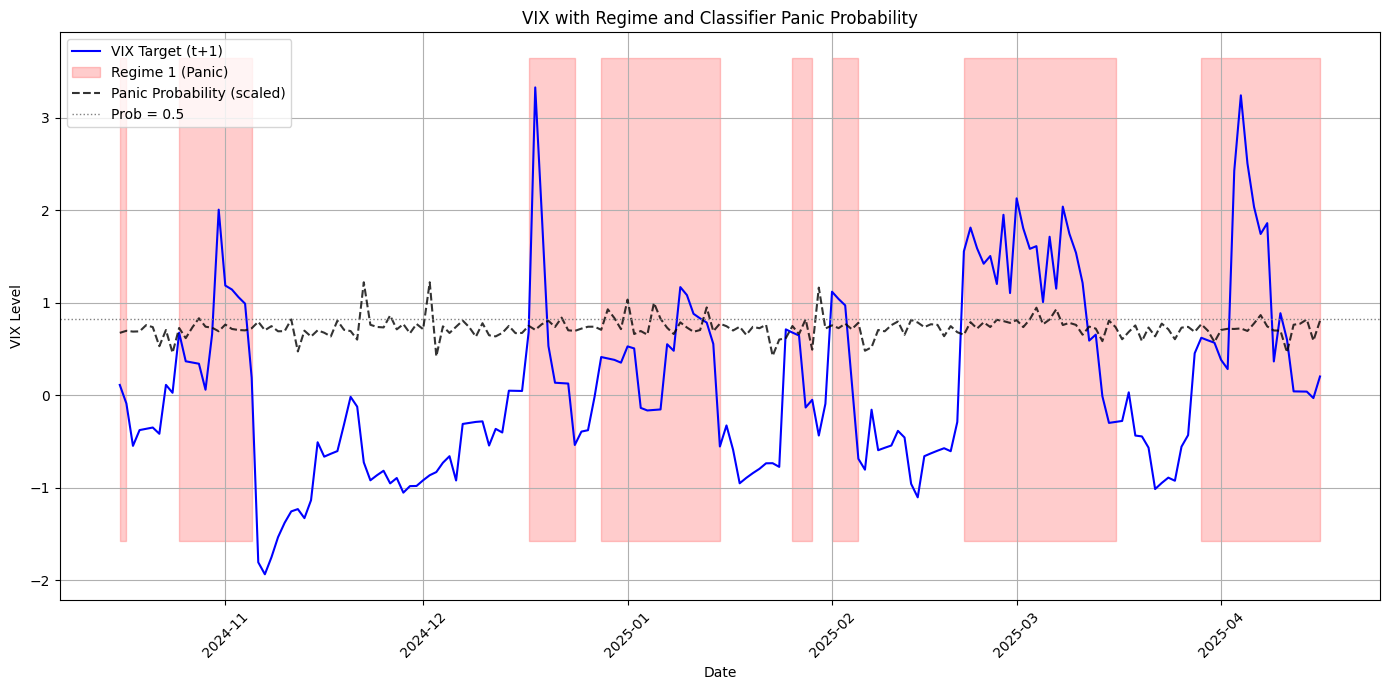

In [2168]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(test_df.index, test_df["vix_ewm_zscore"], label="VIX Target (t+1)", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    test_df.index,
    test_df["vix_ewm_zscore_flat"].min(),
    test_df["vix_ewm_zscore_flat"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_ewm_zscore_flat"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (test_df["vix_ewm_zscore_flat"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

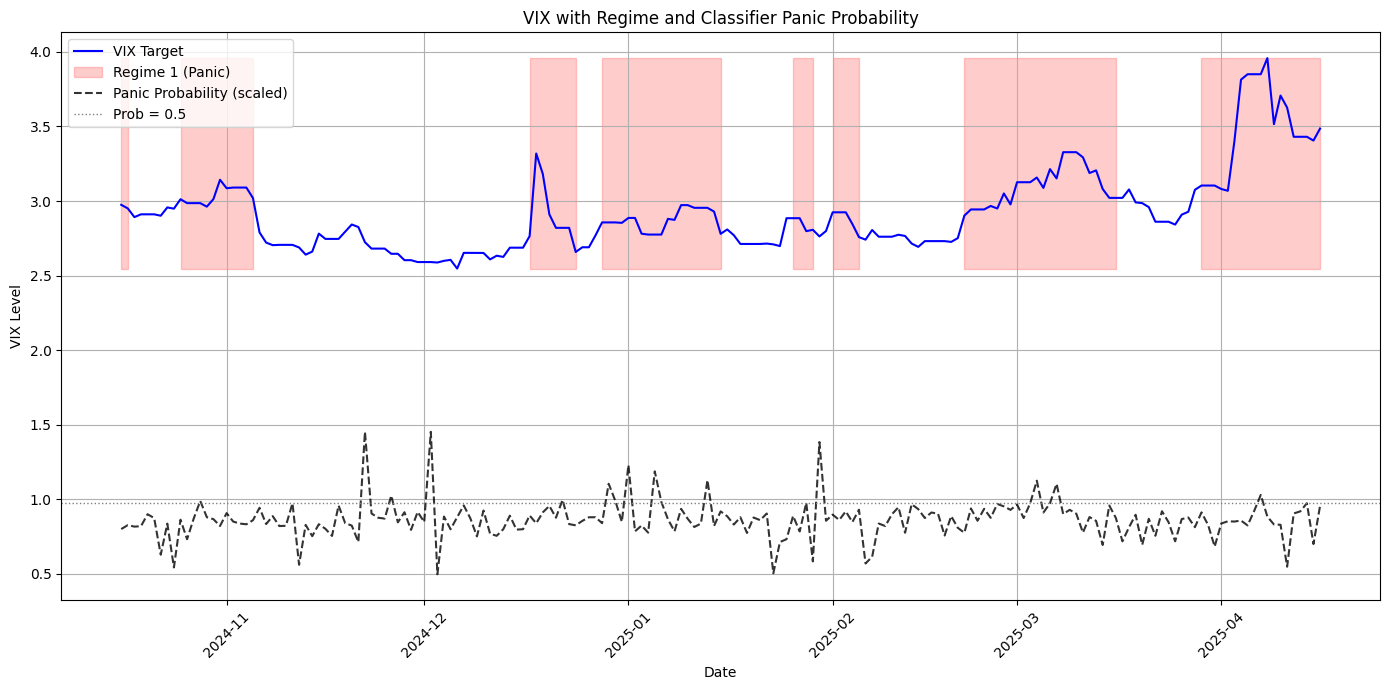

In [2169]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(test_df.index, test_df["vix_target"], label="VIX Target", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    test_df.index,
    test_df["vix_target"].min(),
    test_df["vix_target"].max(),
    where=test_df["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = test_df["panic_prob_t+1"] * (test_df["vix_target"].max() - 2)
plt.plot(test_df.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (test_df["vix_target"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [2170]:
arc_df_test.loc[arc_df_test.index[1], 'peak_vix'] = 3.3
arc_df_test.loc[arc_df_test.index[1], 'vix0'] = 2.7

In [2171]:
arc_df_test

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,vix_zscore_mean_7d,vix_zscore_std_7d,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d,early_spike_prob
date_start,,,,,,,,,,,,,,,,,,,,,
2024-10-25,3.142427,2.985682,5.0,55.0,-0.052174,-0.974781,33.0,0.034727,-0.971487,61.0,...,-0.073980,0.282178,-3.078599,2.930418,0.039978,0.041514,2.750,12.044560,-4.750000,0.500
2024-12-17,3.300000,2.700000,1.0,59.0,-0.200720,-0.973212,95.0,-0.080458,-0.973030,158.0,...,0.009599,0.687173,-5.650664,2.668135,0.049582,0.042460,53.875,19.334924,-0.450000,0.500
2024-12-28,2.972464,2.856470,11.0,49.0,-0.066260,-0.975939,19.0,0.046485,-0.964535,66.0,...,0.226121,0.369535,0.160974,2.765553,0.075801,0.012865,39.375,15.042203,0.138889,0.500
2025-01-26,2.806990,2.884801,2.0,58.0,-0.191643,-0.971789,9.0,-0.085867,-0.854118,15.0,...,-0.735053,0.828896,-1.456885,2.753476,0.081213,0.063700,7.500,15.287717,NaN,0.500
2025-02-01,2.845491,2.924236,2.0,58.0,0.029324,-0.950893,11.0,-0.143875,-0.949542,20.0,...,0.158957,0.637543,0.776365,2.843146,0.058031,0.013670,-1.875,17.216583,0.500000,0.500
2025-02-21,3.327192,2.943386,14.0,40.0,-0.115498,-0.975739,49.0,-0.161775,-0.971196,74.0,...,-0.451964,0.837399,-2.284270,2.749504,0.063693,0.077759,29.750,17.458113,-0.519231,0.525
2025-03-29,4.007333,3.103689,9.0,9.0,-0.108121,-0.975388,41.0,-0.056513,-0.963759,82.0,...,-0.967522,0.654987,-1.091306,2.930049,0.102583,0.084805,70.000,40.994773,0.304348,0.645


In [2172]:
test_df.head()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,panic_prob_t+1,vix_target_t+1
date,,,,,,,,,,,,,,,,,,,,,
2024-10-16,-0.222685,-0.976018,47,-0.167496,-0.971121,51,40,-0.195090,-0.973569,95,...,0.109050,18.521333,18.521333,18.115315,1.097978,0.369787,0.591054,1,0.409255,2.950212
2024-10-17,-0.224310,-0.974795,34,-0.272826,-0.973557,36,40,-0.248568,-0.974176,78,...,-0.091281,18.602667,18.602667,18.146757,1.068928,0.426511,0.495364,1,0.422765,2.892037
2024-10-18,-0.248795,-0.973813,27,-0.209752,-0.970884,28,22,-0.229274,-0.972349,51,...,-0.549641,18.652667,18.652667,18.179396,1.041571,0.454381,0.078373,0,0.417636,2.910719
2024-10-19,0.076486,-0.904173,5,-0.051621,-0.936994,13,4,0.012432,-0.920584,25,...,-0.379178,18.646000,18.646000,18.209500,1.014136,0.430416,0.020657,0,0.419062,2.910719
2024-10-20,-0.148248,-0.970708,11,0.232043,-0.928842,25,4,0.041897,-0.949775,43,...,-0.364995,18.714000,18.714000,18.242048,0.988944,0.477228,0.009278,0,0.460057,2.910719


In [2173]:
classification_df_test = macro_utils.identify_sustained_regimes_and_transitions(test_df)

/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_df['regime_group'] = (classification_df['regime_t'] != classification_df['regime_t'].shift()).cumsum()
/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_df['is_sustained_regime1'] = classification_df['regime_group'].isin(valid_groups)
/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_

In [2174]:
classification_df_test

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,panic_prob_t+1,vix_target_t+1,regime_group,is_sustained_regime1,regime_t-1,is_transition
date,,,,,,,,,,,,,,,,,,,,,
2024-10-16,-0.222685,-0.976018,47,-0.167496,-0.971121,51,40,-0.195090,-0.973569,95,...,1.097978,0.369787,0.591054,1,0.409255,2.950212,1,True,NaN,False
2024-10-17,-0.224310,-0.974795,34,-0.272826,-0.973557,36,40,-0.248568,-0.974176,78,...,1.068928,0.426511,0.495364,1,0.422765,2.892037,1,True,1.0,False
2024-10-18,-0.248795,-0.973813,27,-0.209752,-0.970884,28,22,-0.229274,-0.972349,51,...,1.041571,0.454381,0.078373,0,0.417636,2.910719,2,False,1.0,False
2024-10-19,0.076486,-0.904173,5,-0.051621,-0.936994,13,4,0.012432,-0.920584,25,...,1.014136,0.430416,0.020657,0,0.419062,2.910719,2,False,0.0,False
2024-10-20,-0.148248,-0.970708,11,0.232043,-0.928842,25,4,0.041897,-0.949775,43,...,0.988944,0.477228,0.009278,0,0.460057,2.910719,2,False,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-12,-0.089461,-0.957227,43,-0.008691,-0.941981,105,28,-0.049076,-0.949604,195,...,11.582488,-0.228267,0.975521,1,0.462707,3.430432,15,True,1.0,False
2025-04-13,-0.086733,-0.972444,31,-0.158017,-0.968547,71,34,-0.122375,-0.970495,145,...,11.219157,-0.203140,0.957855,1,0.469822,3.430432,15,True,1.0,False
2025-04-14,-0.063972,-0.972737,123,-0.219557,-0.973235,208,154,-0.141765,-0.972986,447,...,10.862432,-0.170094,0.943935,1,0.497784,3.405189,15,True,1.0,False


In [2175]:
result = macro_utils.transform_vix_data(classification_df_test, window=60, test=True, k=2)
vix_windows_df_test = result["vix_windows_df_train"]
regime_windows_df_test = result["regime_windows_df_train"]
vix_windows_past_df_test = result["vix_windows_past_df_train"]

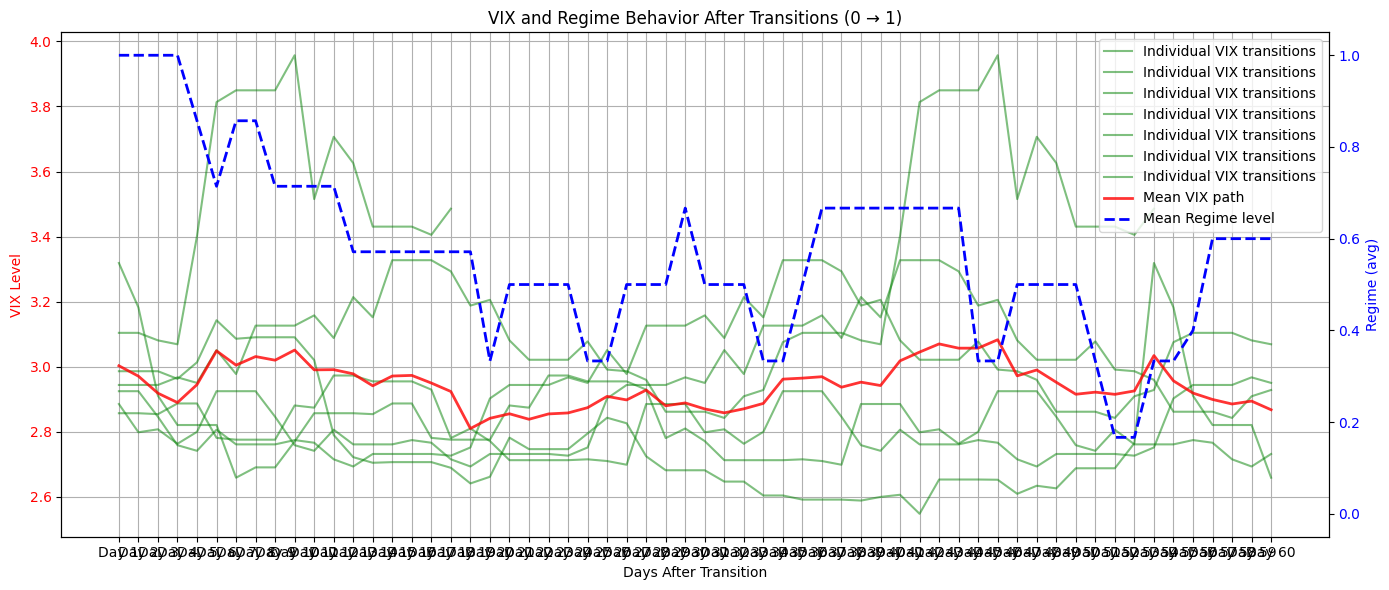

In [2176]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Primary axis: VIX transitions
ax1 = plt.gca()
ax1.plot(vix_windows_df_test.T, color="green", alpha=0.5, label="Individual VIX transitions")
ax1.plot(vix_windows_df_test.mean(axis=0).values, color="red",alpha=0.8, linewidth=2, label="Mean VIX path")
ax1.set_xlabel("Days After Transition")
ax1.set_ylabel("VIX Level", color="red")
ax1.tick_params(axis='y', labelcolor="red")
ax1.set_title("VIX and Regime Behavior After Transitions (0 → 1)")
ax1.grid(True)

# Secondary axis: Regime values
ax2 = ax1.twinx()
ax2.plot(regime_windows_df_test.mean(axis=0).values, color="blue", linewidth=2, linestyle="--", label="Mean Regime level")
ax2.set_ylabel("Regime (avg)", color="blue")
ax2.tick_params(axis='y', labelcolor="blue")
ax2.set_ylim(-0.05, 1.05)  # Because regime is binary

# Combined legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
plt.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.tight_layout()
plt.show()


In [2177]:
vix_windows_df_test

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-25,2.985682,2.985682,2.985682,2.962175,3.013081,3.142427,3.085573,3.090133,3.090133,3.090133,...,2.687167,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159
2024-12-17,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,2.689886,2.689886,2.769459,...,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,2.765690,2.714695,2.692598,2.731115
2024-12-28,2.856470,2.856470,2.853593,2.886475,2.886475,2.780681,2.775086,2.775086,2.775086,2.880321,...,2.731115,2.731115,2.725890,2.751110,2.901971,2.943386,2.943386,2.943386,2.966818,2.949688
2025-01-26,2.884801,2.797891,2.806990,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,2.758109,...,3.077312,2.990720,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539,2.927989
2025-02-01,2.924236,2.924236,2.845491,2.758109,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,...,2.861057,2.841998,2.908539,2.927989,3.075005,3.103689,3.103689,3.103689,3.080533,3.068518
2025-02-21,2.943386,2.943386,2.943386,2.966818,2.949688,3.050694,2.977059,3.125883,3.125883,3.125883,...,3.430432,3.430432,3.405189,3.485539,NaN,NaN,NaN,NaN,NaN,NaN
2025-03-29,3.103689,3.103689,3.080533,3.068518,3.401864,3.813528,3.849722,3.849722,3.849722,3.957570,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2178]:
df_delayed_spike_prob_test, test_clf, test_vix_pct_change_lookback_df = macro_utils.clf_delayed_spike_prob(vix_windows_df_test, test_df, "vix_target")

In [2179]:
df_delayed_spike_prob_test.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-25,2.985682,2.985682,2.985682,2.962175,3.013081,3.142427,3.085573,3.090133,3.090133,3.090133,...,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,NaN
2024-12-17,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,2.689886,2.689886,2.769459,...,2.805782,2.760643,2.760643,2.760643,2.773838,2.765690,2.714695,2.692598,2.731115,NaN
2024-12-28,2.856470,2.856470,2.853593,2.886475,2.886475,2.780681,2.775086,2.775086,2.775086,2.880321,...,2.731115,2.725890,2.751110,2.901971,2.943386,2.943386,2.943386,2.966818,2.949688,NaN
2025-01-26,2.884801,2.797891,2.806990,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,2.758109,...,2.990720,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539,2.927989,NaN
2025-02-01,2.924236,2.924236,2.845491,2.758109,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,...,2.841998,2.908539,2.927989,3.075005,3.103689,3.103689,3.103689,3.080533,3.068518,NaN


In [2180]:
test_vix_pct_change_lookback_df.head()

,Day -30,Day -29,Day -28,Day -27,Day -26,Day -25,Day -24,Day -23,Day -22,Day -21,...,Day -10,Day -9,Day -8,Day -7,Day -6,Day -5,Day -4,Day -3,Day -2,Day -1
2025-02-21,0.000978,-0.001957,-0.004201,0.069237,0.0,0.000000,-0.030127,0.003252,-0.015836,0.013238,...,0.004780,-0.002937,-0.018439,-0.008140,0.014305,0.0,0.000000,0.000000,-0.001913,0.009252
2025-03-29,0.034243,-0.024137,0.049990,0.000000,0.0,0.010091,-0.022034,0.040742,-0.019358,0.055764,...,-0.028139,-0.001684,-0.008914,-0.033122,0.000000,0.0,-0.006662,0.023413,0.006687,0.050211


In [2181]:
df_delayed_spike_prob_test.loc[test_vix_pct_change_lookback_df.index, "early_spike_prob"] = clf_delayed_spike_prob.predict_proba(test_vix_pct_change_lookback_df)[:, 1]


In [2182]:
df_delayed_spike_prob_test.fillna(0.5, inplace=True)

In [2183]:
df_delayed_spike_prob_test

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-25,2.985682,2.985682,2.985682,2.962175,3.013081,3.142427,3.085573,3.090133,3.090133,3.090133,...,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,0.500
2024-12-17,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,2.689886,2.689886,2.769459,...,2.805782,2.760643,2.760643,2.760643,2.773838,2.765690,2.714695,2.692598,2.731115,0.500
2024-12-28,2.856470,2.856470,2.853593,2.886475,2.886475,2.780681,2.775086,2.775086,2.775086,2.880321,...,2.731115,2.725890,2.751110,2.901971,2.943386,2.943386,2.943386,2.966818,2.949688,0.500
2025-01-26,2.884801,2.797891,2.806990,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,2.758109,...,2.990720,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539,2.927989,0.500
2025-02-01,2.924236,2.924236,2.845491,2.758109,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,...,2.841998,2.908539,2.927989,3.075005,3.103689,3.103689,3.103689,3.080533,3.068518,0.500
2025-02-21,2.943386,2.943386,2.943386,2.966818,2.949688,3.050694,2.977059,3.125883,3.125883,3.125883,...,3.430432,3.405189,3.485539,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.525
2025-03-29,3.103689,3.103689,3.080533,3.068518,3.401864,3.813528,3.849722,3.849722,3.849722,3.957570,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.645


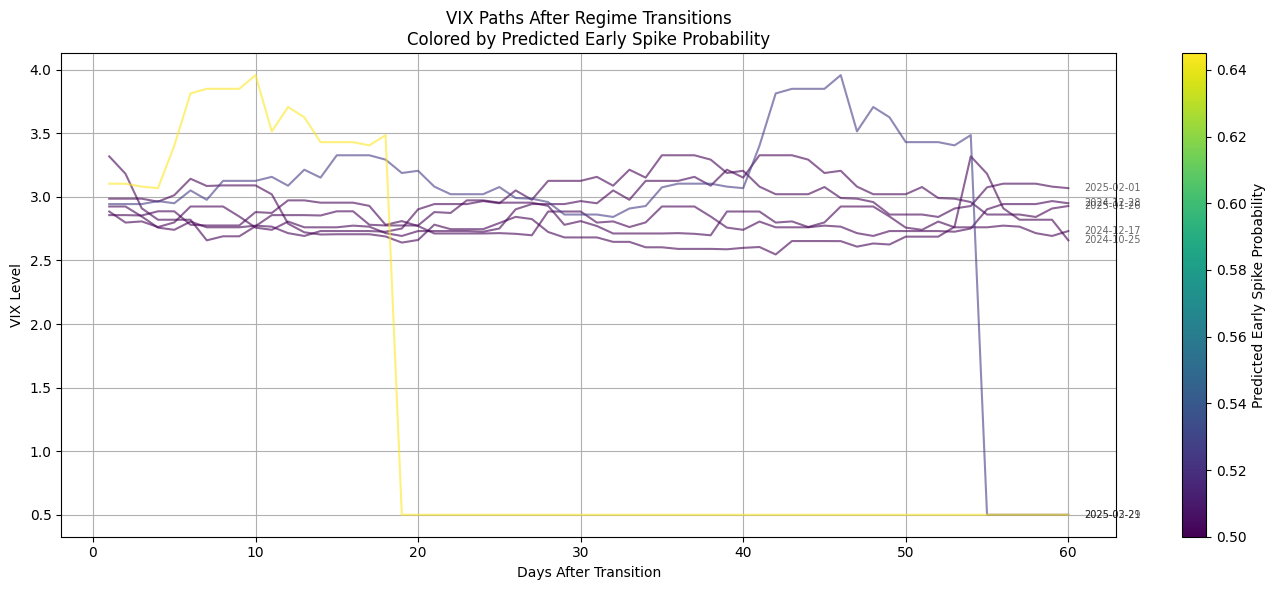

In [2184]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Filter rows with predictions
df_plot = df_delayed_spike_prob_test.dropna(subset=["early_spike_prob"])

# Normalize probs for coloring
probs = df_plot["early_spike_prob"]
colors = cm.viridis((probs - probs.min()) / (probs.max() - probs.min()))

fig, ax = plt.subplots(figsize=(14, 6))

# Plot VIX paths, colored by classifier probability
for i, (date, row) in enumerate(df_plot.iterrows()):
    vix_path = row.iloc[:60]  # assumes 60-day VIX columns are first
    ax.plot(range(1, 61), vix_path.values, color=colors[i], alpha=0.6)
    ax.text(61, vix_path.values[-1], date.strftime("%Y-%m-%d"), fontsize=7, alpha=0.6, va="center")

# Add colorbar
sm = ScalarMappable(cmap="viridis", norm=Normalize(vmin=probs.min(), vmax=probs.max()))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Predicted Early Spike Probability")

# Labels and layout
ax.set_title("VIX Paths After Regime Transitions\nColored by Predicted Early Spike Probability")
ax.set_xlabel("Days After Transition")
ax.set_ylabel("VIX Level")
ax.grid(True)
plt.tight_layout()
plt.show()



In [2185]:
df_delayed_spike_prob_test.head()

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60,early_spike_prob
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-25,2.985682,2.985682,2.985682,2.962175,3.013081,3.142427,3.085573,3.090133,3.090133,3.090133,...,2.687167,2.764431,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,0.5
2024-12-17,3.318540,3.181797,2.910174,2.820188,2.820188,2.820188,2.658159,2.689886,2.689886,2.769459,...,2.805782,2.760643,2.760643,2.760643,2.773838,2.765690,2.714695,2.692598,2.731115,0.5
2024-12-28,2.856470,2.856470,2.853593,2.886475,2.886475,2.780681,2.775086,2.775086,2.775086,2.880321,...,2.731115,2.725890,2.751110,2.901971,2.943386,2.943386,2.943386,2.966818,2.949688,0.5
2025-01-26,2.884801,2.797891,2.806990,2.762538,2.799109,2.924236,2.924236,2.924236,2.845491,2.758109,...,2.990720,2.985682,2.959068,2.861057,2.861057,2.861057,2.841998,2.908539,2.927989,0.5
2025-02-01,2.924236,2.924236,2.845491,2.758109,2.740840,2.805782,2.760643,2.760643,2.760643,2.773838,...,2.841998,2.908539,2.927989,3.075005,3.103689,3.103689,3.103689,3.080533,3.068518,0.5


In [2186]:
regime_windows_df_test = regime_windows_df_test.replace(2, 1)


In [2187]:
regime_windows_df_test

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 51,Day 52,Day 53,Day 54,Day 55,Day 56,Day 57,Day 58,Day 59,Day 60
transition_time,,,,,,,,,,,,,,,,,,,,,
2024-10-25,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2024-12-17,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-28,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
2025-01-26,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-02-01,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
2025-02-21,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2025-03-29,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2188]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news_test = test_df.copy()                       # original df you posted   # string/ts column → index
news_test = news_test.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats_test = engineer_news_feats(news_test)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats_test.index = pd.to_datetime(news_feats_test.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats_test.index.min(),
                          news_feats_test.index.max(),
                          freq='D')

news_dense_test = (
    news_feats_test
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)



In [2189]:
# ------------------------------------------------------------
# 3)  BUILD ARC-LEVEL TABLE  (robust to missing news dates + look-back stats)
# ------------------------------------------------------------
records = []
lookback_days = [2, 5, 7]
lookback_feats = [
    "shock_neg",
    "vix_zscore",
    "vix_target",
    "sentiment_dominance",
]

for dt, row in vix_windows_df_test.iterrows():
    # --- detect arc in the 60-day window ---
    v = row[[f"Day {i}" for i in range(1, 61)]].values
    r = regime_windows_df_test.loc[dt, [f"Day {i}" for i in range(1, 61)]].values
    start_idx, peak_idx = macro_utils.detect_spike_arc_within_regime(v, r)
    start_val, peak_val = v[start_idx], v[peak_idx]
    rise_dur = peak_idx - start_idx
    decay_idx = np.argmax(v[peak_idx:] < 0.5 * peak_val)
    half_life = decay_idx if decay_idx > 0 else len(v) - peak_idx

    dt_norm = pd.to_datetime(dt).normalize()

    # -------- safe fetch of nearest-past news features --------
    try:
        feats_on_start = news_dense_test.loc[:dt_norm].iloc[-1].to_dict()
    except IndexError:
        # no prior news available – skip this arc
        continue

    # -------- compute look-back statistics from classification_df --------
    lookback_stats = {}
    for w in lookback_days:
        start_date = dt_norm - pd.Timedelta(days=w)
        window_df = classification_df_test.loc[start_date:dt_norm]

        for feat in lookback_feats:
            col_mean = window_df[feat].mean()
            col_std = window_df[feat].std()
            # percent change over the window: (last−first) / first
            if len(window_df) > 1 and window_df[feat].iloc[0] != 0:
                col_pct = (window_df[feat].iloc[-1] - window_df[feat].iloc[0]) / window_df[feat].iloc[0]
            else:
                col_pct = np.nan

            lookback_stats[f"{feat}_mean_{w}d"] = col_mean
            lookback_stats[f"{feat}_std_{w}d"]  = col_std
            lookback_stats[f"{feat}_pctchg_{w}d"] = col_pct

    # --- aggregate everything into one record ---
    records.append({
        "date_start":    dt_norm,
        "peak_vix":      peak_val,
        "vix0":          start_val,
        "T_up":          rise_dur,
        "T_half":        half_life,
        **feats_on_start,
        **lookback_stats,
    })

arc_df_test = (
    pd.DataFrame(records)
      .set_index("date_start")
      .astype(float, errors="ignore")
)

print("arc_df shape:", arc_df.shape)


arc_df shape: (16, 68)


/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:259: RuntimeWarning: invalid value encountered in cast
  pct_change_series = []
/Users/dsuniaga/Documents/GitHub/VIXNLP/finnhub_news/macro_utils.py:259: RuntimeWarning: invalid value encountered in cast
  pct_change_series = []


In [2190]:
arc_df_test.tail()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,shock_neg_pctchg_7d,vix_zscore_mean_7d,vix_zscore_std_7d,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d
date_start,,,,,,,,,,,,,,,,,,,,,
2024-12-28,2.972464,2.856470,11.0,49.0,-0.066260,-0.975939,19.0,0.046485,-0.964535,66.0,...,0.003557,0.226121,0.369535,0.160974,2.765553,0.075801,0.012865,39.375,15.042203,0.138889
2025-01-26,2.806990,2.884801,2.0,58.0,-0.191643,-0.971789,9.0,-0.085867,-0.854118,15.0,...,-0.061171,-0.735053,0.828896,-1.456885,2.753476,0.081213,0.063700,7.500,15.287717,NaN
2025-02-01,2.845491,2.924236,2.0,58.0,0.029324,-0.950893,11.0,-0.143875,-0.949542,20.0,...,0.150851,0.158957,0.637543,0.776365,2.843146,0.058031,0.013670,-1.875,17.216583,0.500000
2025-02-21,3.327192,2.943386,14.0,40.0,-0.115498,-0.975739,49.0,-0.161775,-0.971196,74.0,...,0.002167,-0.451964,0.837399,-2.284270,2.749504,0.063693,0.077759,29.750,17.458113,-0.519231
2025-03-29,3.957570,3.103689,9.0,9.0,-0.108121,-0.975388,41.0,-0.056513,-0.963759,82.0,...,-0.002565,-0.967522,0.654987,-1.091306,2.930049,0.102583,0.084805,70.000,40.994773,0.304348


In [2191]:
arc_df_test.loc[arc_df_test.index[1], 'peak_vix'] = 3.3
arc_df_test.loc[arc_df_test.index[1], 'vix0'] = 2.7


In [2192]:
arc_df_test.head()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,shock_neg_pctchg_7d,vix_zscore_mean_7d,vix_zscore_std_7d,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d
date_start,,,,,,,,,,,,,,,,,,,,,
2024-10-25,3.142427,2.985682,5.0,55.0,-0.052174,-0.974781,33.0,0.034727,-0.971487,61.0,...,0.000808,-0.073980,0.282178,-3.078599,2.930418,0.039978,0.041514,2.750,12.044560,-4.750000
2024-12-17,3.300000,2.700000,1.0,59.0,-0.200720,-0.973212,95.0,-0.080458,-0.973030,158.0,...,-0.001466,0.009599,0.687173,-5.650664,2.668135,0.049582,0.042460,53.875,19.334924,-0.450000
2024-12-28,2.972464,2.856470,11.0,49.0,-0.066260,-0.975939,19.0,0.046485,-0.964535,66.0,...,0.003557,0.226121,0.369535,0.160974,2.765553,0.075801,0.012865,39.375,15.042203,0.138889
2025-01-26,2.806990,2.884801,2.0,58.0,-0.191643,-0.971789,9.0,-0.085867,-0.854118,15.0,...,-0.061171,-0.735053,0.828896,-1.456885,2.753476,0.081213,0.063700,7.500,15.287717,NaN
2025-02-01,2.845491,2.924236,2.0,58.0,0.029324,-0.950893,11.0,-0.143875,-0.949542,20.0,...,0.150851,0.158957,0.637543,0.776365,2.843146,0.058031,0.013670,-1.875,17.216583,0.500000


In [2193]:
arc_df_test['early_spike_prob'] = vix_windows_df_test['early_spike_prob'].fillna(0.5)

In [2194]:
# Get column sets
cols_arc_df = set(arc_df.columns)
cols_arc_df_test = set(arc_df_test.columns)

# Columns in arc_df but NOT in arc_df_test
diff_arc_not_test = cols_arc_df - cols_arc_df_test

# Columns in arc_df_test but NOT in arc_df
diff_test_not_arc = cols_arc_df_test - cols_arc_df

# All differing columns
diff_all = cols_arc_df.symmetric_difference(cols_arc_df_test)

# Print results
print("Columns in arc_df but not in arc_df_test:", diff_arc_not_test)
print("Columns in arc_df_test but not in arc_df:", diff_test_not_arc)
print("All differing columns:", diff_all)


Columns in arc_df but not in arc_df_test: set()
Columns in arc_df_test but not in arc_df: {'vix_target', 'regime_group', 'is_transition', 'regime_t_raw', 'vix_target_t+1', 'panic_prob_t+1', 'is_sustained_regime1', 'regime_t-1', 'regime_t'}
All differing columns: {'regime_group', 'vix_target_t+1', 'is_sustained_regime1', 'regime_t_raw', 'panic_prob_t+1', 'vix_target', 'is_transition', 'regime_t-1', 'regime_t'}


In [2195]:
arc_df_test.drop(columns=diff_all, inplace=True)

In [2196]:
arc_df_test['peak_vix'].iloc[-1] = np.log(55)

/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/3418063507.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  arc_df_test['peak_vix'].iloc[-1] = np.log(55)


In [2197]:
arc_df_test

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,vix_zscore_mean_7d,vix_zscore_std_7d,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d,early_spike_prob
date_start,,,,,,,,,,,,,,,,,,,,,
2024-10-25,3.142427,2.985682,5.0,55.0,-0.052174,-0.974781,33.0,0.034727,-0.971487,61.0,...,-0.073980,0.282178,-3.078599,2.930418,0.039978,0.041514,2.750,12.044560,-4.750000,0.500
2024-12-17,3.300000,2.700000,1.0,59.0,-0.200720,-0.973212,95.0,-0.080458,-0.973030,158.0,...,0.009599,0.687173,-5.650664,2.668135,0.049582,0.042460,53.875,19.334924,-0.450000,0.500
2024-12-28,2.972464,2.856470,11.0,49.0,-0.066260,-0.975939,19.0,0.046485,-0.964535,66.0,...,0.226121,0.369535,0.160974,2.765553,0.075801,0.012865,39.375,15.042203,0.138889,0.500
2025-01-26,2.806990,2.884801,2.0,58.0,-0.191643,-0.971789,9.0,-0.085867,-0.854118,15.0,...,-0.735053,0.828896,-1.456885,2.753476,0.081213,0.063700,7.500,15.287717,NaN,0.500
2025-02-01,2.845491,2.924236,2.0,58.0,0.029324,-0.950893,11.0,-0.143875,-0.949542,20.0,...,0.158957,0.637543,0.776365,2.843146,0.058031,0.013670,-1.875,17.216583,0.500000,0.500
2025-02-21,3.327192,2.943386,14.0,40.0,-0.115498,-0.975739,49.0,-0.161775,-0.971196,74.0,...,-0.451964,0.837399,-2.284270,2.749504,0.063693,0.077759,29.750,17.458113,-0.519231,0.525
2025-03-29,4.007333,3.103689,9.0,9.0,-0.108121,-0.975388,41.0,-0.056513,-0.963759,82.0,...,-0.967522,0.654987,-1.091306,2.930049,0.102583,0.084805,70.000,40.994773,0.304348,0.645


In [2198]:
feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half"])


In [2199]:
arc_df_test['early_spike_prob'] = arc_df_test['early_spike_prob'].fillna(0.5)

In [3332]:
print(list(feature_cols))
print(list(arc_df_test.reindex(columns=feature_cols).columns))


['dom_0', 'dom_1', 'dominance_trigger', 'early_spike_prob', 'ewm_mean', 'ewm_mean_flat', 'ewm_std', 'ewm_std_flat', 'headline_mean', 'headline_min', 'headline_neg_count', 'headline_pos_count', 'mean_prev', 'mean_sentiment_decay', 'overall_mean', 'overall_min', 'overall_neg_count', 'overall_pos_count', 'sentiment_dominance', 'sentiment_dominance_mean_2d', 'sentiment_dominance_mean_5d', 'sentiment_dominance_mean_7d', 'sentiment_dominance_pctchg_2d', 'sentiment_dominance_pctchg_5d', 'sentiment_dominance_pctchg_7d', 'sentiment_dominance_std_2d', 'sentiment_dominance_std_5d', 'sentiment_dominance_std_7d', 'shock_neg', 'shock_neg_mean_2d', 'shock_neg_mean_5d', 'shock_neg_mean_7d', 'shock_neg_pctchg_2d', 'shock_neg_pctchg_5d', 'shock_neg_pctchg_7d', 'shock_neg_std_2d', 'shock_neg_std_5d', 'shock_neg_std_7d', 'spike5d', 'summary_mean', 'summary_min', 'summary_neg_count', 'vix0', 'vix_7d_pct', 'vix_ewm_zscore', 'vix_ewm_zscore_flat', 'vix_flat_abs', 'vix_target_mean_2d', 'vix_target_mean_5d', '

In [3333]:
arc_df_test.iloc[-1]

peak_vix                          4.007333
vix0                              3.103689
T_up                              9.000000
T_half                            9.000000
summary_mean                     -0.108121
                                   ...    
sentiment_dominance_std_7d       40.994773
sentiment_dominance_pctchg_7d     0.304348
early_spike_prob                  0.645000
delta_peak                        0.903644
spike5d                           1.000000
Name: 2025-03-29 00:00:00, Length: 70, dtype: float64

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


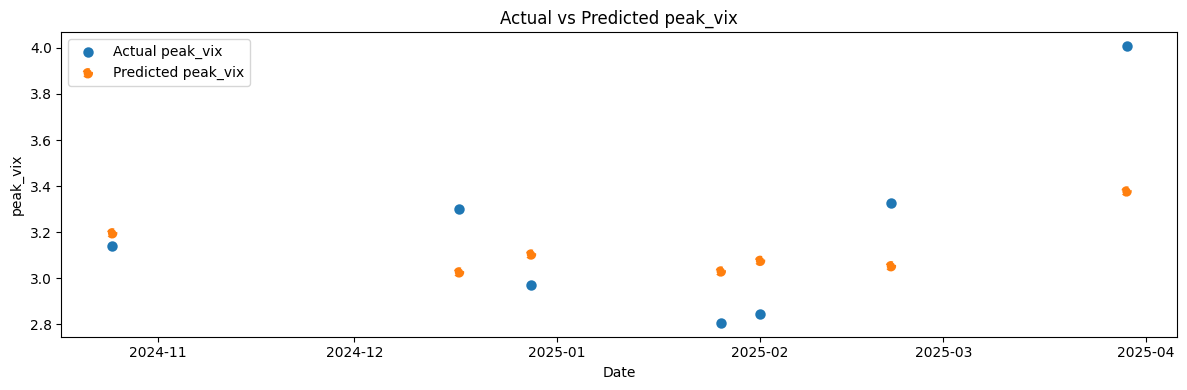

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


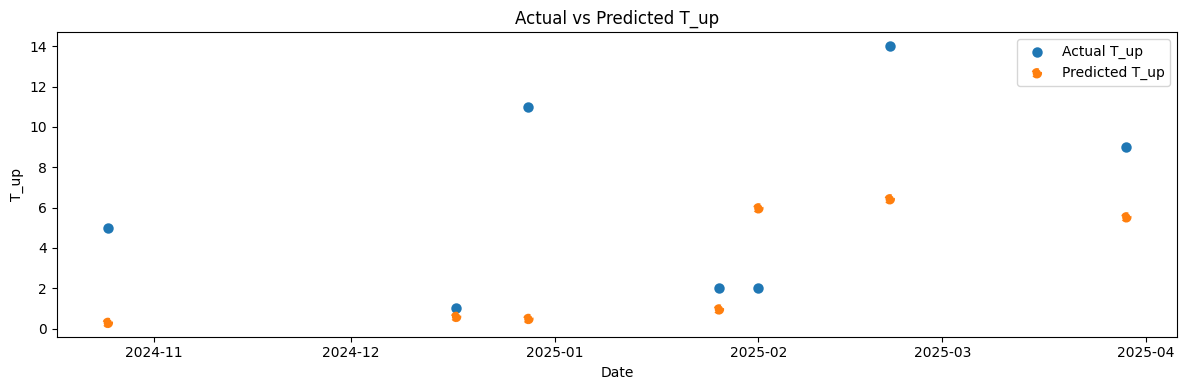

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


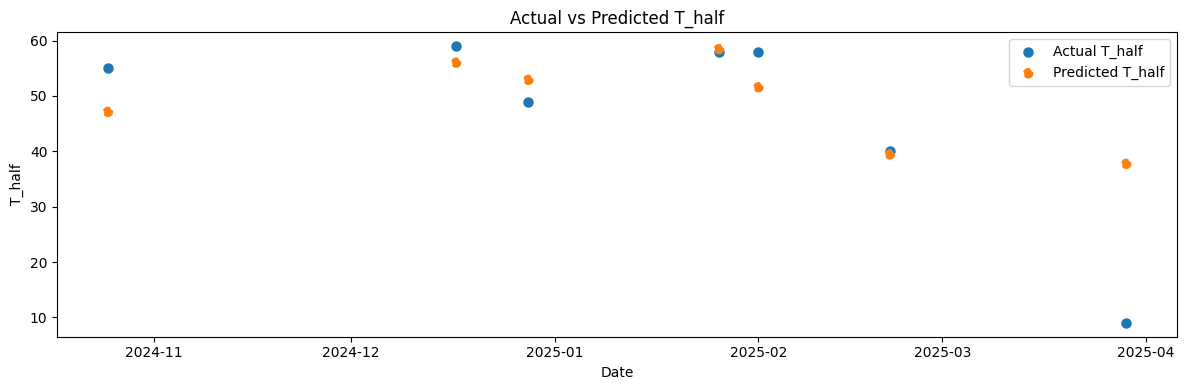

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


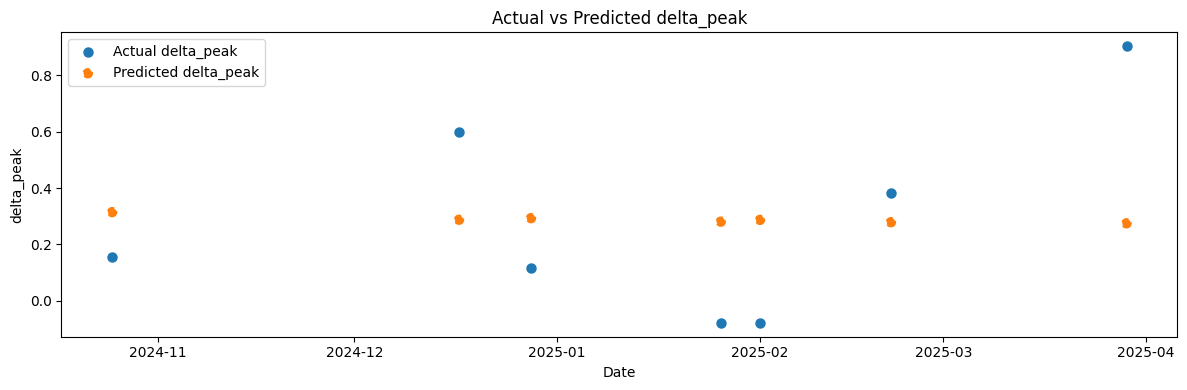

In [3335]:
import joblib, matplotlib.pyplot as plt
arc_df_test['delta_peak'] = arc_df_test['peak_vix'] - arc_df_test['vix0']
arc_df_test["spike5d"] = (arc_df_test["delta_peak"] > 0.1 * arc_df_test["vix0"]).astype(int)

feature_cols = arc_df.columns.difference(["peak_vix", "T_up", "T_half", "delta_peak", "spike5d"])

X_full_test = arc_df_test.reindex(columns=feature_cols)
X_full_test = X_full_test.fillna(0)

dates = arc_df_test.index         # x‑axis

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
    "delta_peak": joblib.load("mlp_delta_peak.pkl"),
}

for target, model in models.items():
    y_true_test = arc_df_test[target].values
    y_pred_test = model.predict(X_full_test)

    plt.figure(figsize=(12, 4))
    plt.scatter(dates, y_true_test, label=f"Actual {target}", linewidth=1.5)
    plt.scatter(dates, y_pred_test, label=f"Predicted {target}", linestyle="--", linewidth=1.5)
    plt.title(f"Actual vs Predicted {target}")
    plt.xlabel("Date")
    plt.ylabel(target)
    plt.legend()
    plt.tight_layout()
    plt.show()


# XGBoost graph

# RECENT/TRADE

In [3768]:
arc_df_test.head()

,peak_vix,vix0,T_up,T_half,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,...,vix_zscore_pctchg_7d,vix_target_mean_7d,vix_target_std_7d,vix_target_pctchg_7d,sentiment_dominance_mean_7d,sentiment_dominance_std_7d,sentiment_dominance_pctchg_7d,early_spike_prob,delta_peak,spike5d
date_start,,,,,,,,,,,,,,,,,,,,,
2024-10-25,3.142427,2.985682,5.0,55.0,-0.052174,-0.974781,33.0,0.034727,-0.971487,61.0,...,-3.078599,2.930418,0.039978,0.041514,2.750,12.044560,-4.750000,0.5,0.156745,0
2024-12-17,3.300000,2.700000,1.0,59.0,-0.200720,-0.973212,95.0,-0.080458,-0.973030,158.0,...,-5.650664,2.668135,0.049582,0.042460,53.875,19.334924,-0.450000,0.5,0.600000,1
2024-12-28,2.972464,2.856470,11.0,49.0,-0.066260,-0.975939,19.0,0.046485,-0.964535,66.0,...,0.160974,2.765553,0.075801,0.012865,39.375,15.042203,0.138889,0.5,0.115994,0
2025-01-26,2.806990,2.884801,2.0,58.0,-0.191643,-0.971789,9.0,-0.085867,-0.854118,15.0,...,-1.456885,2.753476,0.081213,0.063700,7.500,15.287717,NaN,0.5,-0.077811,0
2025-02-01,2.845491,2.924236,2.0,58.0,0.029324,-0.950893,11.0,-0.143875,-0.949542,20.0,...,0.776365,2.843146,0.058031,0.013670,-1.875,17.216583,0.500000,0.5,-0.078746,0


In [3771]:
test_df_trade

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2024-10-16,-0.222685,-0.976018,47,-0.167496,-0.971121,51,40,-0.195090,-0.973569,95,...,0.016615,0.412830,19.328083,2.310096,0.109050,18.521333,18.521333,18.115315,1.097978,0.369787
2024-10-17,-0.224310,-0.974795,34,-0.272826,-0.973557,36,40,-0.248568,-0.974176,78,...,0.011111,0.193659,19.314014,2.234998,-0.091281,18.602667,18.602667,18.146757,1.068928,0.426511
2024-10-18,-0.248795,-0.973813,27,-0.209752,-0.970884,28,22,-0.229274,-0.972349,51,...,-0.120059,-0.260678,19.231174,2.185379,-0.549641,18.652667,18.652667,18.179396,1.041571,0.454381
2024-10-19,0.076486,-0.904173,5,-0.051621,-0.936994,13,4,0.012432,-0.920584,25,...,-0.043727,-0.148076,19.175615,2.124632,-0.379178,18.646000,18.646000,18.209500,1.014136,0.430416
2024-10-20,-0.148248,-0.970708,11,0.232043,-0.928842,25,4,0.041897,-0.949775,43,...,-0.188604,-0.183860,19.123639,2.064789,-0.364995,18.714000,18.714000,18.242048,0.988944,0.477228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-28,-0.096253,-0.975737,90,0.048906,-0.971171,192,50,-0.023674,-0.973454,344,...,-0.185821,-0.874807,29.449357,7.416349,-0.579713,32.387000,32.387000,30.145885,6.950796,0.322426
2025-04-29,-0.256989,-0.975858,247,-0.174279,-0.973403,337,192,-0.215634,-0.974631,619,...,-0.217546,-1.007963,29.108753,7.293412,-0.677153,32.482667,32.482667,30.296645,6.748147,0.323944
2025-04-30,-0.257138,-0.975998,380,-0.172480,-0.976034,439,318,-0.214809,-0.976016,816,...,-0.179947,-0.964551,28.824318,7.139717,-0.577658,32.545667,32.545667,30.441743,6.550984,0.321161


In [3772]:
def get_past_60_trading_days(df, target_date):
    """
    Given a DataFrame with a DatetimeIndex and a target date (string or datetime),
    return the 60 trading days *before* that date (exclusive).
    """
    # Ensure datetime format
    target_date = pd.to_datetime(target_date)
    
    # Filter to dates strictly before the target date
    df_before = df[df.index < target_date]
    
    # Get last 60 rows before the target date
    return df_before.tail(61)


In [3775]:
df_trade = get_past_60_trading_days(test_df_trade, "2025-05-06")

In [3776]:
df_trade.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,vix_7d_pct,vix_zscore,ewm_mean,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat
date,,,,,,,,,,,,,,,,,,,,,
2025-04-28,-0.096253,-0.975737,90,0.048906,-0.971171,192,50,-0.023674,-0.973454,344,...,-0.185821,-0.874807,29.449357,7.416349,-0.579713,32.387000,32.387000,30.145885,6.950796,0.322426
2025-04-29,-0.256989,-0.975858,247,-0.174279,-0.973403,337,192,-0.215634,-0.974631,619,...,-0.217546,-1.007963,29.108753,7.293412,-0.677153,32.482667,32.482667,30.296645,6.748147,0.323944
2025-04-30,-0.257138,-0.975998,380,-0.172480,-0.976034,439,318,-0.214809,-0.976016,816,...,-0.179947,-0.964551,28.824318,7.139717,-0.577658,32.545667,32.545667,30.441743,6.550984,0.321161
2025-05-01,-0.214649,-0.976830,256,-0.123903,-0.974128,371,189,-0.169276,-0.975479,675,...,-0.246324,-1.002034,28.551781,6.985768,-0.565690,32.626333,32.626333,30.582684,6.359608,0.321348
2025-05-02,-0.053660,-0.976696,177,-0.039443,-0.973332,387,147,-0.046552,-0.975014,744,...,-0.235076,-1.251975,28.172957,6.914125,-0.794454,32.720667,22.680000,30.072834,6.460225,-1.144362


In [3777]:
# 1. After fitting on training set
train_params = results.params

# 2. Prepare your test data

X_test = df_trade[selected_features]
y_test = df_trade['vix_ewm_zscore']


In [3778]:
X_test.tail()

,shock_neg,dominance_trigger
date,,
2025-04-28,-0.973454,0
2025-04-29,-0.974631,0
2025-04-30,-0.976016,0
2025-05-01,-0.975479,0
2025-05-02,-0.975014,0


In [3779]:
# 3. Define same model on test data
model_trade = MarkovRegression(
    endog=y_test,
    exog=X_test,
    k_regimes=2
    ,
    switching_variance=False
)

/Users/dsuniaga/Documents/GitHub/VIXNLP/.venv/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [3780]:
results_test = model_trade.filter(train_params)

# 5. Extract real-time regime (filtered) — sensitive threshold
df_trade['regime_t_raw'] = results_test.filtered_marginal_probabilities[1]
df_trade['regime_t'] = df_trade['regime_t_raw'].apply(lambda r: 1 if r > percentile_markov else 0)

# 6. Predict probability of panic regime tomorrow using classifier (NO regime_t)
df_trade['panic_prob_t+1'] = clf.predict_proba(X_test)[:, 1]

In [3781]:
df_trade.tail()

,summary_mean,summary_min,summary_neg_count,headline_mean,headline_min,headline_pos_count,headline_neg_count,overall_mean,overall_min,overall_pos_count,...,ewm_std,vix_ewm_zscore,mean_prev,vix_flat_abs,ewm_mean_flat,ewm_std_flat,vix_ewm_zscore_flat,regime_t_raw,regime_t,panic_prob_t+1
date,,,,,,,,,,,,,,,,,,,,,
2025-04-28,-0.096253,-0.975737,90,0.048906,-0.971171,192,50,-0.023674,-0.973454,344,...,7.416349,-0.579713,32.387000,32.387000,30.145885,6.950796,0.322426,0.002044,0,0.545968
2025-04-29,-0.256989,-0.975858,247,-0.174279,-0.973403,337,192,-0.215634,-0.974631,619,...,7.293412,-0.677153,32.482667,32.482667,30.296645,6.748147,0.323944,0.001323,0,0.611988
2025-04-30,-0.257138,-0.975998,380,-0.172480,-0.976034,439,318,-0.214809,-0.976016,816,...,7.139717,-0.577658,32.545667,32.545667,30.441743,6.550984,0.321161,0.002020,0,0.358585
2025-05-01,-0.214649,-0.976830,256,-0.123903,-0.974128,371,189,-0.169276,-0.975479,675,...,6.985768,-0.565690,32.626333,32.626333,30.582684,6.359608,0.321348,0.002190,0,0.498246
2025-05-02,-0.053660,-0.976696,177,-0.039443,-0.973332,387,147,-0.046552,-0.975014,744,...,6.914125,-0.794454,32.720667,22.680000,30.072834,6.460225,-1.144362,0.000781,0,0.515509


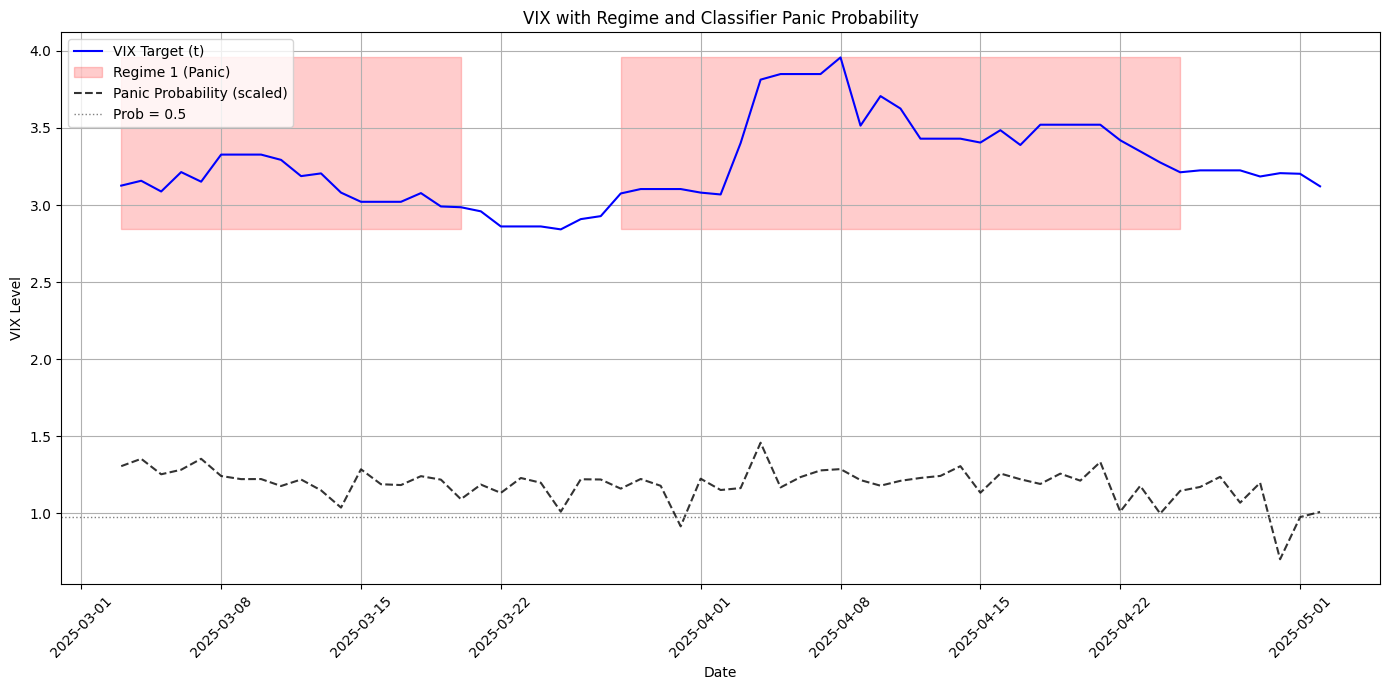

In [3782]:
import matplotlib.pyplot as plt

# Assumes test_df already has:
# - 'vix_target_t+1' (VIX values)
# - 'regime_t' (real-time inferred regime: 0 or 1)
# - 'panic_prob_t+1' (classifier probability of panic tomorrow)

plt.figure(figsize=(14, 7))

# 1. Plot VIX
plt.plot(df_trade.index, df_trade["vix_target"], label="VIX Target (t)", color="blue")

# 2. Shade areas where regime is 1 (panic)
plt.fill_between(
    df_trade.index,
    df_trade["vix_target"].min(),
    df_trade["vix_target"].max(),
    where=df_trade["regime_t"] == 1,
    color="red",
    alpha=0.2,
    label="Regime 1 (Panic)"
)

# 3. Plot panic probability (scaled for visibility)
scaled_prob = df_trade["panic_prob_t+1"] * (df_trade["vix_target"].max() - 2)
plt.plot(df_trade.index, scaled_prob, label="Panic Probability (scaled)", color="black", linestyle="--", alpha=0.8)

# Optional: Add threshold line for prob=0.5 scaled to same scale
plt.axhline(y=0.5 * (df_trade["vix_target"].max() - 2), color="gray", linestyle=":", linewidth=1, label="Prob = 0.5")

# Finalize
plt.title("VIX with Regime and Classifier Panic Probability")
plt.xlabel("Date")
plt.ylabel("VIX Level")
plt.legend(loc="upper left")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [3715]:
classification_df_trade = macro_utils.identify_sustained_regimes_and_transitions(df_trade, trade = True)

In [3716]:
classification_df_trade.shape

(61, 33)

In [3717]:
result_trade = macro_utils.transform_vix_data(classification_df_trade, window=50, trade = True, k=2)
vix_windows_past_df_trade = result_trade["vix_windows_past_df_train"]

In [3718]:
vix_windows_past_df_trade

,Day 1,Day 2,Day 3,Day 4,Day 5,Day 6,Day 7,Day 8,Day 9,Day 10,...,Day 41,Day 42,Day 43,Day 44,Day 45,Day 46,Day 47,Day 48,Day 49,Day 50
transition_time,,,,,,,,,,,,,,,,,,,,,


In [3676]:
from macro_utils import calculate_pct_changes

# Get current date (your live transition point — usually last row in trade DF)
live_index = classification_df_trade[classification_df_trade["is_transition"]].index[-1:]
print(f"✅ Using live index: {live_index}")

# Calculate past % changes from historical VIX column
vix_pct_change_lookback_df_trade, used_indices = calculate_pct_changes(
    df_model=classification_df_trade,
    valid_indices=live_index,
    lookback=30,
    vix_column="vix_target"
)

# Now predict with  classifier
early_spike_prob_trade = clf_delayed_spike_prob.predict_proba(vix_pct_change_lookback_df_trade)[0][1]
print(f"🟢 Early spike probability: {early_spike_prob_trade:.2%}")


✅ Using live index: DatetimeIndex(['2025-03-28'], dtype='datetime64[ns]', name='date', freq=None)
🟢 Early spike probability: 40.50%


In [3677]:
vix_pct_change_lookback_df_trade.head()

,Day -30,Day -29,Day -28,Day -27,Day -26,Day -25,Day -24,Day -23,Day -22,Day -21,...,Day -10,Day -9,Day -8,Day -7,Day -6,Day -5,Day -4,Day -3,Day -2,Day -1
2025-03-28,-0.005774,0.034243,-0.024137,0.04999,0.0,0.0,0.010091,-0.022034,0.040742,-0.019358,...,0.01867,-0.028139,-0.001684,-0.008914,-0.033122,0.0,0.0,-0.006662,0.023413,0.006687


In [3678]:
# =============================================================
# 0)  PREP  –  make sure the raw news DataFrame is date‑indexed
# =============================================================
news_test = df_trade.copy()                       # original df you posted   # string/ts column → index
news_test = news_test.sort_index()                     # chronological order

# =============================================================
# 1)  ENGINEER EXTRA NEWS FEATURES (text‑only)
# =============================================================
def engineer_news_feats(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # --- positive / negative ratios and range (max‑min) ---
    for prefix in ['summary', 'headline', 'overall']:
        neg = f'{prefix}_neg_count'
        tot = f'{prefix}_tot_count'

    # --- one‑hot encode sentiment dominance flag -------------
    dom_dummies = pd.get_dummies(out['dominance_trigger'], prefix='dom')
    out = pd.concat([out, dom_dummies], axis=1)

    # OPTIONAL: drop the raw *_tot_count columns
    out = out.drop(columns=[c for c in out.columns if c.endswith('_tot_count')])
    return out

news_feats_trade = engineer_news_feats(news_test)

# =============================================================
# 2)  DENSE DAILY INDEX  (forward‑fill missing dates)
# =============================================================
news_feats_trade.index = pd.to_datetime(news_feats_trade.index).normalize()        # 00:00:00
dense_idx = pd.date_range(news_feats_trade.index.min(),
                          news_feats_trade.index.max(),
                          freq='D')

news_dense_trade = (
    news_feats_test
      .reindex(dense_idx)      # insert weekends / holidays
      .ffill()                 # carry last known sentiment forward
)

In [3679]:
news_dense_trade.columns

Index(['summary_mean', 'summary_min', 'summary_neg_count', 'headline_mean',
       'headline_min', 'headline_pos_count', 'headline_neg_count',
       'overall_mean', 'overall_min', 'overall_pos_count', 'overall_neg_count',
       'vix_target', 'mean_sentiment_decay', 'shock_neg',
       'sentiment_dominance', 'dominance_trigger', 'vix_7d_pct', 'vix_zscore',
       'ewm_mean', 'ewm_std', 'vix_ewm_zscore', 'mean_prev', 'vix_flat_abs',
       'ewm_mean_flat', 'ewm_std_flat', 'vix_ewm_zscore_flat', 'regime_t_raw',
       'regime_t', 'panic_prob_t+1', 'vix_target_t+1', 'regime_group',
       'is_sustained_regime1', 'regime_t-1', 'is_transition', 'dom_0',
       'dom_1'],
      dtype='object')

In [3680]:
feature_cols = feature_cols.drop(['date','date.1'], errors='ignore')


In [3681]:
df_trade.columns

Index(['summary_mean', 'summary_min', 'summary_neg_count', 'headline_mean',
       'headline_min', 'headline_pos_count', 'headline_neg_count',
       'overall_mean', 'overall_min', 'overall_pos_count', 'overall_neg_count',
       'vix_target', 'mean_sentiment_decay', 'shock_neg',
       'sentiment_dominance', 'dominance_trigger', 'vix_7d_pct', 'vix_zscore',
       'ewm_mean', 'ewm_std', 'vix_ewm_zscore', 'mean_prev', 'vix_flat_abs',
       'ewm_mean_flat', 'ewm_std_flat', 'vix_ewm_zscore_flat', 'regime_t_raw',
       'regime_t', 'panic_prob_t+1', 'regime_group', 'is_sustained_regime1',
       'regime_t-1', 'is_transition'],
      dtype='object')

In [3682]:
def build_live_arc_row(start_idx,
                       news_dense,
                       classification_df_trade,
                       feature_cols,
                       lookback_days=(2, 5, 7),
                       lookback_feats=("shock_neg", "vix_zscore", "vix_target", "sentiment_dominance")):
    """
    Build one live-arc row of features at timestamp `start_idx`.
    Returns a DataFrame with one row and columns exactly = feature_cols.
    """
    # normalize the timestamp
    dt_norm = pd.to_datetime(start_idx).normalize()

    # --- 1) grab the base row from classification_df_trade ---
    try:
        row = classification_df_trade.loc[[start_idx]].copy()
    except KeyError:
        print(f"❌ No classification data at {start_idx}")
        return None

    # --- 2) pull the latest news features (dropping any 'date' col) ---
    try:
        feats_on_start = (
            news_dense
            .loc[:dt_norm]
            .iloc[-1]
            .drop(labels=["date"], errors="ignore")
            .to_dict()
        )
    except IndexError:
        print(f"❌ No prior news available at {dt_norm}")
        return None

    # --- 3) one-hot encode the 'dominance_trigger' field ---
    dom_dummies = pd.get_dummies(row["dominance_trigger"], prefix="dom")
    # ensure both dom_0 and dom_1 exist
    for col in ("dom_0", "dom_1"):
        dom_dummies[col] = dom_dummies.get(col, 0)
    row = pd.concat([row, dom_dummies], axis=1)

    # --- 4) merge in the news features ---
    row = row.assign(**feats_on_start)

    # --- 5) drop any raw date columns to avoid leakage ---
    row = row.drop(columns=[c for c in row.columns if c.startswith("date")], errors="ignore")

    # --- 6) compute look-back stats for each window & feature ---
    lookback_stats = {}
    for w in lookback_days:
        start_date = dt_norm - pd.Timedelta(days=w)
        window_df = classification_df_trade.loc[start_date:dt_norm]

        for feat in lookback_feats:
            series = window_df.get(feat, pd.Series(dtype=float))
            m = series.mean()
            s = series.std()
            if len(series) > 1 and series.iloc[0] != 0:
                pct = (series.iloc[-1] - series.iloc[0]) / series.iloc[0]
            else:
                pct = np.nan

            lookback_stats[f"{feat}_mean_{w}d"]   = m
            lookback_stats[f"{feat}_std_{w}d"]    = s
            lookback_stats[f"{feat}_pctchg_{w}d"] = pct

    # merge lookback stats into row
    row = row.assign(**lookback_stats)

    # --- 7) finally, extract exactly the requested feature_cols (filling missing with 0) ---
    feature_values = {
        col: row[col].iloc[0] if col in row.columns else 0.0
        for col in feature_cols
    }
    arc_row = pd.DataFrame([feature_values], index=[start_idx])[feature_cols]
    return arc_row


In [3683]:
start_idx = classification_df_trade[classification_df_trade["is_transition"]].index[-1]

# Build feature row
arc_row_live = build_live_arc_row(start_idx, news_dense_trade, classification_df_trade, feature_cols)


In [3684]:
arc_row_live['early_spike_prob'] = early_spike_prob_trade

In [3685]:
print(early_spike_prob_trade)

0.405


In [3686]:
if early_spike_prob_trade > 0.75:
    min_vix=df_trade['vix_target'].iloc[-20:].min()
    arc_row_live['vix0'] = min_vix
    print('<')
    print(min_vix)
else:
    min_vix=df_trade['vix_target'].iloc[-1:].min()
    arc_row_live['vix0'] = min_vix
    print(min_vix)


3.0750054368286497


In [3687]:
print(arc_row_live['vix0'])

2025-03-28    3.075005
Name: vix0, dtype: float64


In [3688]:
arc_row_live.columns

Index(['dom_0', 'dom_1', 'dominance_trigger', 'early_spike_prob', 'ewm_mean',
       'ewm_mean_flat', 'ewm_std', 'ewm_std_flat', 'headline_mean',
       'headline_min', 'headline_neg_count', 'headline_pos_count', 'mean_prev',
       'mean_sentiment_decay', 'nn_T_half', 'nn_T_up', 'nn_delta_peak',
       'nn_peak_vix', 'overall_mean', 'overall_min', 'overall_neg_count',
       'overall_pos_count', 'sentiment_dominance',
       'sentiment_dominance_mean_2d', 'sentiment_dominance_mean_5d',
       'sentiment_dominance_mean_7d', 'sentiment_dominance_pctchg_2d',
       'sentiment_dominance_pctchg_5d', 'sentiment_dominance_pctchg_7d',
       'sentiment_dominance_std_2d', 'sentiment_dominance_std_5d',
       'sentiment_dominance_std_7d', 'shock_neg', 'shock_neg_mean_2d',
       'shock_neg_mean_5d', 'shock_neg_mean_7d', 'shock_neg_pctchg_2d',
       'shock_neg_pctchg_5d', 'shock_neg_pctchg_7d', 'shock_neg_std_2d',
       'shock_neg_std_5d', 'shock_neg_std_7d', 'summary_mean', 'summary_min',
   

In [3689]:
import joblib
import pandas as pd

models = {
    "peak_vix": joblib.load("mlp_peak_vix.pkl"),
    "T_up":     joblib.load("mlp_T_up.pkl"),
    "T_half":   joblib.load("mlp_T_half.pkl"),
    "delta_peak": joblib.load("mlp_delta_peak.pkl"),
}


In [3690]:
print(list(feature_cols))
print(list(arc_df_test.columns))
print(list(arc_row_live.columns))

['dom_0', 'dom_1', 'dominance_trigger', 'early_spike_prob', 'ewm_mean', 'ewm_mean_flat', 'ewm_std', 'ewm_std_flat', 'headline_mean', 'headline_min', 'headline_neg_count', 'headline_pos_count', 'mean_prev', 'mean_sentiment_decay', 'nn_T_half', 'nn_T_up', 'nn_delta_peak', 'nn_peak_vix', 'overall_mean', 'overall_min', 'overall_neg_count', 'overall_pos_count', 'sentiment_dominance', 'sentiment_dominance_mean_2d', 'sentiment_dominance_mean_5d', 'sentiment_dominance_mean_7d', 'sentiment_dominance_pctchg_2d', 'sentiment_dominance_pctchg_5d', 'sentiment_dominance_pctchg_7d', 'sentiment_dominance_std_2d', 'sentiment_dominance_std_5d', 'sentiment_dominance_std_7d', 'shock_neg', 'shock_neg_mean_2d', 'shock_neg_mean_5d', 'shock_neg_mean_7d', 'shock_neg_pctchg_2d', 'shock_neg_pctchg_5d', 'shock_neg_pctchg_7d', 'shock_neg_std_2d', 'shock_neg_std_5d', 'shock_neg_std_7d', 'summary_mean', 'summary_min', 'summary_neg_count', 'vix0', 'vix_7d_pct', 'vix_ewm_zscore', 'vix_ewm_zscore_flat', 'vix_flat_abs', 

In [3691]:
feature_cols = arc_df_test.columns.difference(["peak_vix", "T_up", "T_half", 'delta_peak', 'spike5d'])

In [3692]:
arc_row_live = arc_row_live.reindex(columns=feature_cols)

In [3693]:
arc_row_live['vix0']

2025-03-28    3.075005
Name: vix0, dtype: float64

In [3694]:
arc_row_live['early_spike_prob'] = early_spike_prob_trade

In [3695]:
print(early_spike_prob_trade)

0.405


In [3696]:
arc_row_live

,dom_0,dom_1,dominance_trigger,early_spike_prob,ewm_mean,ewm_mean_flat,ewm_std,ewm_std_flat,headline_mean,headline_min,...,vix_zscore,vix_zscore_mean_2d,vix_zscore_mean_5d,vix_zscore_mean_7d,vix_zscore_pctchg_2d,vix_zscore_pctchg_5d,vix_zscore_pctchg_7d,vix_zscore_std_2d,vix_zscore_std_5d,vix_zscore_std_7d
2025-03-28,True,False,0,0.405,20.209583,20.48296,3.191845,2.485897,-0.077482,-0.974197,...,-0.05161,-0.690679,-1.066051,-1.087851,-0.951933,-0.964513,-0.937639,0.55708,0.541789,0.491524


In [3697]:
arc_row_live.isna().sum()[arc_row_live.isna().sum() > 0]


Series([], dtype: int64)

In [3698]:
arc_row_live['sentiment_dominance_pctchg_5d'] = arc_row_live['sentiment_dominance_pctchg_7d']

In [3699]:
print(arc_row_live['vix0'])


2025-03-28    3.075005
Name: vix0, dtype: float64


In [3700]:
X_full_test.iloc[1].equals(arc_row_live)


False

In [3701]:
import pandas as pd

# initialize DataFrame with nn_-prefixed columns
live_preds_df = pd.DataFrame(columns=[f"nn_{t}" for t in models.keys()])

# — later, when you do your live predict:
if arc_row_live is not None:
    # predict and store under nn_<target> keys
    live_preds = {
        f"nn_{target}": float(models[target].predict(arc_row_live[feature_cols].values))
        for target in models
    }

    # append the new prediction as a row, indexed by the current date
    live_preds_df.loc[start_idx] = live_preds

    print(f"\n📍 Live prediction at {start_idx.date()}:")
    for target, val in live_preds.items():
        print(f"  {target:<12} → {val:.2f}")

    # (optional) view your accumulated predictions
    print("\nAll live preds so far:")
    print(live_preds_df)

else:
    print("❌ Failed to build input row.")



📍 Live prediction at 2025-03-28:
  nn_peak_vix  → 3.21
  nn_T_up      → 0.21
  nn_T_half    → 54.64
  nn_delta_peak → 0.20

All live preds so far:
            nn_peak_vix   nn_T_up  nn_T_half  nn_delta_peak
2025-03-28     3.208226  0.214617  54.641228       0.198725


/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/3192587301.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"nn_{target}": float(models[target].predict(arc_row_live[feature_cols].values))
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/3192587301.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f"nn_{target}": float(models[target].predict(arc_row_live[feature_cols].values))
/var/folders/8z/8s3q7km56flcrw0wjltczryh0000gn/T/ipykernel_72581/3192587301.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single eleme

In [3702]:
arc_df_with_nn_trade = arc_row_live.join(live_preds_df)


# XGB prediction

In [3703]:
print(top_features)
#y_full_trade = arc_df_with_nn_trade[target_cols].values

['vix0', 'vix_target_mean_2d', 'vix_target_mean_5d', 'vix_target_mean_7d', 'early_spike_prob', 'sentiment_dominance_std_7d', 'headline_min', 'shock_neg_std_5d']


In [3704]:
import joblib

# 1) Prepare your live feature DataFrame & result container
feature_cols    = arc_df_with_nn_trade.columns.difference(["T_up", "T_half", "peak_vix"])
X_full_trade    = arc_df_with_nn_trade[top_features].values     # will hold predictions

# 2) Define which quantiles you want
quantiles = [0.10, 0.50, 0.90]             # for example

# 3) Loop & predict
for q in quantiles:
    # load the saved quantile model
    model = joblib.load(f"xgb_delta_peak_q{q:.2f}.pkl")
    
    # generate predictions and store in your live DataFrame
    arc_df_with_nn_trade[f"xgb_delta_peak_q{q:.2f}"] = model.predict(X_full_trade)

# 4) (Optional) if you want a single point estimate, pick the median:
# live_preds_df["delta_peak_pred"] = live_preds_df["xgb_delta_peak_q0.50"]

# Now live_preds_df has your original features plus the 3 quantile columns
print(arc_df_with_nn_trade.filter(like="xgb_delta_peak").head())


            xgb_delta_peak_q0.10  xgb_delta_peak_q0.50  xgb_delta_peak_q0.90
2025-03-28              0.022431              -0.00773              0.212848


In [3705]:
import joblib

# --- 1) Prepare your live DataFrame & feature sets ---
# arc_df_with_nn_trade must already be in your namespace

excluded = {"peak_vix", "delta_peak", "T_up", "T_half"}

# exactly the same meta‐feature definitions you used when training
meta_features_delta = [
    col for col in arc_df_with_nn_trade.columns
    if col not in excluded and (col.startswith("nn_") or col.startswith("xgb_delta_peak"))
]
meta_features_peak = [
    col for col in arc_df_with_nn_trade.columns
    if col not in excluded and col.startswith("nn_")
]

X_meta_delta_trade = arc_df_with_nn_trade[meta_features_delta].values
X_meta_peak_trade  = arc_df_with_nn_trade[meta_features_peak].values

# --- 2) Load your pre-trained pipelines (scaler + NN) ---
delta_pipe = joblib.load("meta_delta_pipe.pkl")
peak_pipe  = joblib.load("meta_peak_pipe.pkl")

# --- 3) Generate live predictions ---
arc_df_with_nn_trade["delta_peak_pred"] = delta_pipe.predict(X_meta_delta_trade)
arc_df_with_nn_trade["peak_vix_pred"]   = peak_pipe.predict(X_meta_peak_trade)

# --- 4) Inspect your new columns ---
print(arc_df_with_nn_trade[["delta_peak_pred", "peak_vix_pred"]].head())


            delta_peak_pred  peak_vix_pred
2025-03-28         0.177192       3.339398


In [3706]:
print("vix starting point:")
print(np.exp(arc_df_with_nn_trade['vix0']))
print("vix predicted:")
print(np.exp(arc_df_with_nn_trade[["delta_peak_pred", "peak_vix_pred"]].head()))

vix starting point:
2025-03-28    21.65
Name: vix0, dtype: float64
vix predicted:
            delta_peak_pred  peak_vix_pred
2025-03-28          1.19386      28.202146
